## GE Stock Prediction
Here we are going to predict GE stock prices. Example from https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

In [1]:
# Import Required Libraries
# Graph Functions
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
# from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import pandas as pd
import os

## Import and Inspect Data

In [2]:
display(os.getcwd())
df_ge = pd.read_csv('ge_stock.txt', engine='python')
df_ge.tail()

'C:\\Users\\pooja\\Downloads\\HW_6_Pooja Yakkala'

,Date,Open,High,Low,Close,Volume,OpenInt
14053,2017-11-06,20.52,20.530,20.08,20.13,60641787,0
14054,2017-11-07,20.17,20.250,20.12,20.21,41622851,0
14055,2017-11-08,20.21,20.320,20.07,20.12,39672190,0
14056,2017-11-09,20.04,20.071,19.85,19.99,50831779,0
14057,2017-11-10,19.98,20.680,19.90,20.49,100698474,0


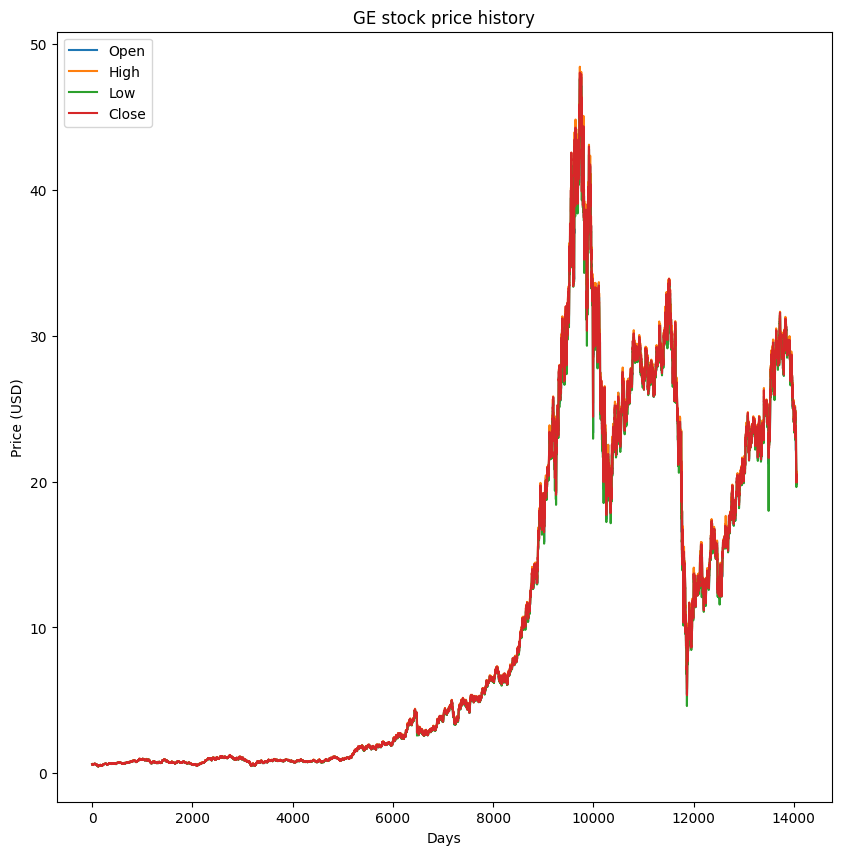

In [3]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

## Preprocess the Data
We need to normalize the data in order to improve convergence time.

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
#train_cols = ["Open","High","Low","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
Xtrain = min_max_scaler.fit_transform(x)
Xtest = min_max_scaler.transform(df_test.loc[:,train_cols])

# Train scalar only on Y
stock_min_max = MinMaxScaler()
stock_min_max.fit_transform(np.reshape(df_train.loc[:, "Close"].values, (-1, 1)))

Train and Test size 11246 2812


C:\Users\pooja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


array([[0.00338425],
       [0.00338425],
       [0.00321827],
       ...,
       [0.56564471],
       [0.57270398],
       [0.57677987]])

## Reshape the Data for Training
Our current dataset is not in a form suitable for training.

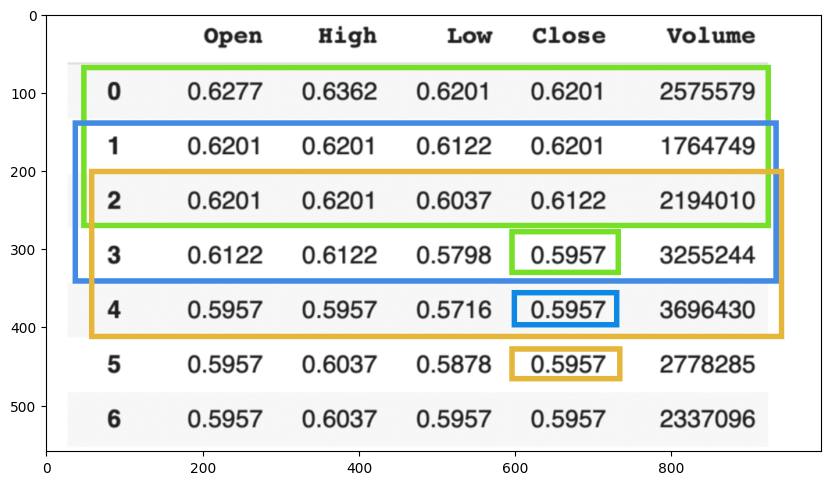

In [5]:
import matplotlib.image as mpimg
img = mpimg.imread('stock_training.png')
plt.imshow(img)

In [6]:
def build_timeseries(mat, y_col_index, TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0-4):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i+4, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat


In [7]:
TIME_STEPS = 3
BATCH_SIZE = 32
x_t, y_t = build_timeseries(Xtrain, 3, TIME_STEPS)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(Xtest, 3, TIME_STEPS)
Xval, Xtest_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
Yval, Ytest_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (11243, 3, 5) (11243,)
length of time-series i/o (2809, 3, 5) (2809,)


## Model Creation
Time to create our Keras Model

In [8]:
# Import functions from Keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, InputLayer
lstm_model = Sequential()
lstm_model.add(InputLayer(batch_input_shape = (BATCH_SIZE, TIME_STEPS, 
                                            x_t.shape[2])))
lstm_model.add(LSTM(100, stateful = True, dropout=0.0, recurrent_dropout=0.0))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='linear'))
lstm_model.compile(loss='mean_squared_error', 
                   optimizer='sgd',
                   metrics=['mae'])

# Plot Model
The following code is to plot our created model.

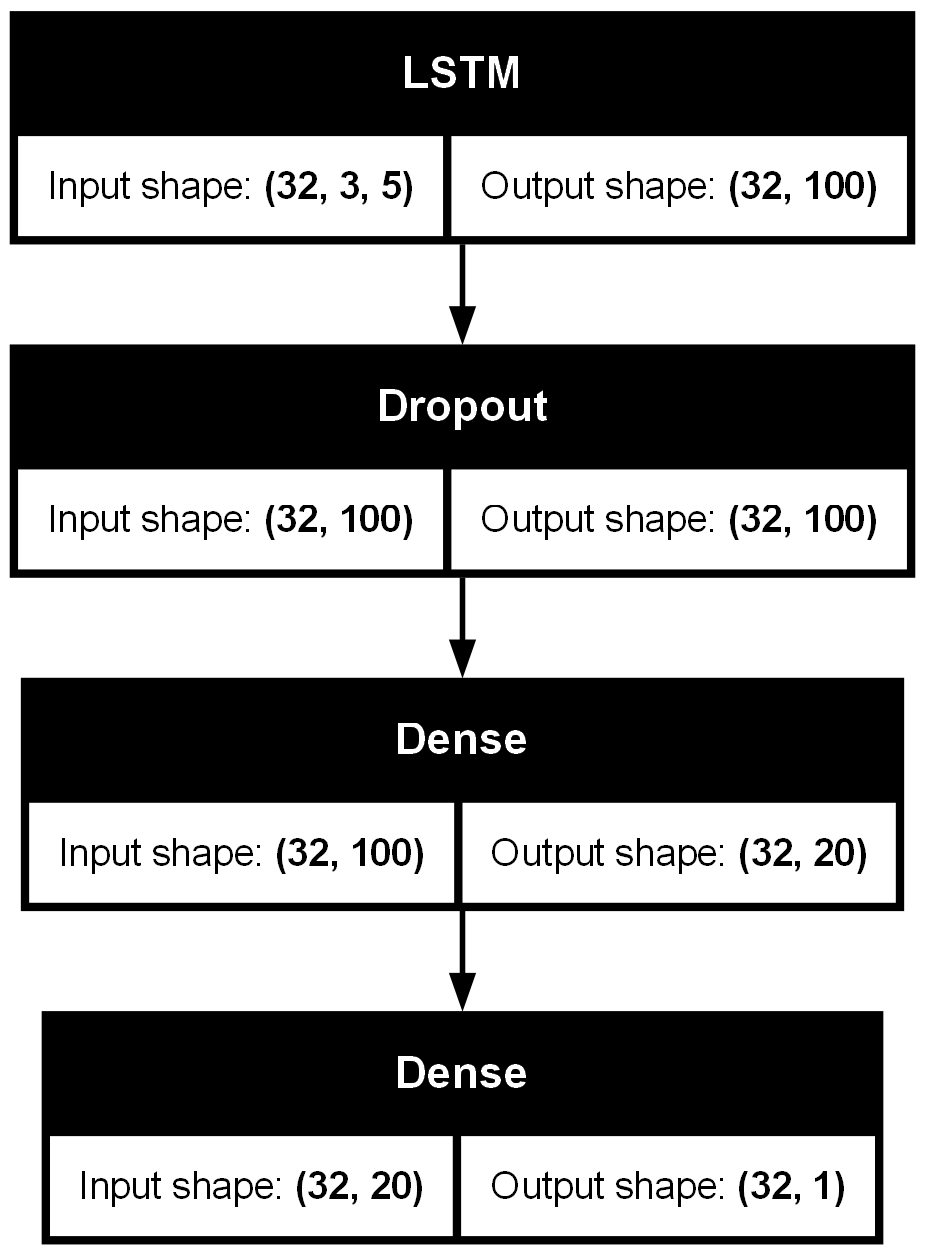

In [9]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
#from keras.utils import model_to_dot
plot_model(lstm_model, show_shapes = True)

# Train and Plot Model Performance

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0480 - mae: 0.1521 - val_loss: 0.0051 - val_mae: 0.0553
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0162 - mae: 0.0863 - val_loss: 0.0156 - val_mae: 0.1170
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0113 - mae: 0.0743 - val_loss: 0.0157 - val_mae: 0.1170
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0086 - mae: 0.0624 - val_loss: 0.0165 - val_mae: 0.1198
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0072 - mae: 0.0567 - val_loss: 0.0129 - val_mae: 0.1044
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0066 - mae: 0.0533 - val_loss: 0.0130 - val_mae: 0.1048
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0053 - mae: 0.0487 - val_loss: 0.0107 - val_mae: 0.0940
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0051 - mae: 0.0470 - val_loss: 0.0089 - val_mae: 0.0854
Epoch 9/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - lo

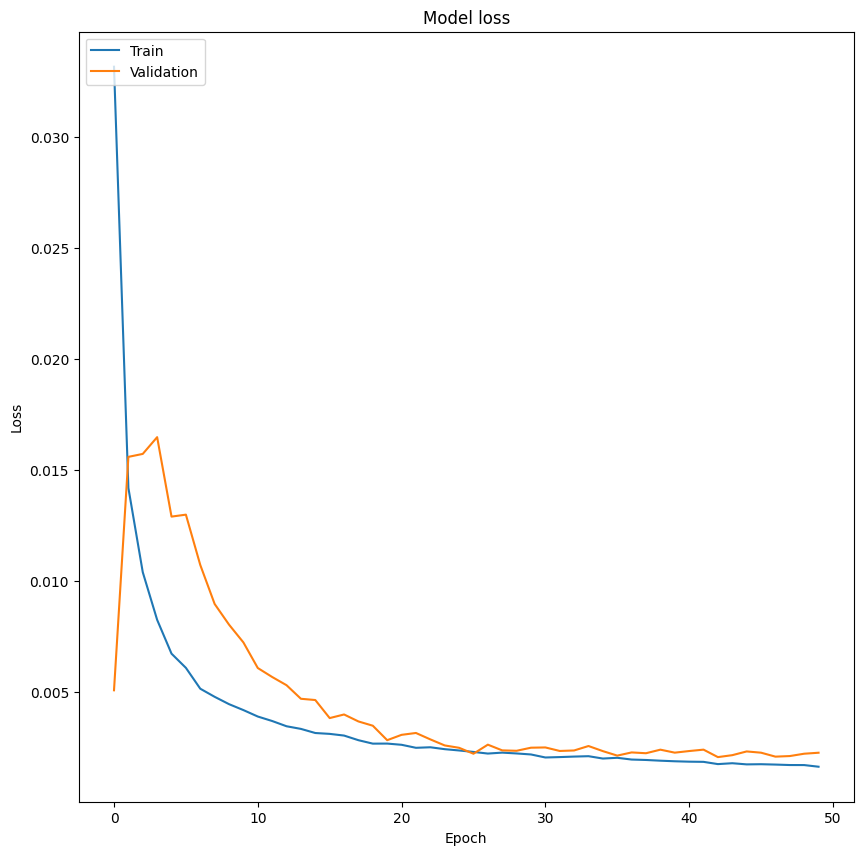

In [10]:
history = lstm_model.fit(x_t, y_t,
          batch_size=32, epochs=50, verbose=1,
          validation_data=(trim_dataset(Xval, BATCH_SIZE), 
                           trim_dataset(Yval, BATCH_SIZE)))

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


# Generate Performance Metrics

In [11]:
score = lstm_model.evaluate(x_t, y_t, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1] )

351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0730e-04 - mae: 0.0111
Test score: 0.0007763865869492292
Test accuracy: 0.017497682943940163


# Plot Validation Data against Actual

In [12]:
predicted = lstm_model.predict(trim_dataset(Xval, BATCH_SIZE))
display(predicted)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[0.5463886 ],
       [0.5460247 ],
       [0.5462017 ],
       ...,
       [0.35431615],
       [0.3534538 ],
       [0.35241118]], dtype=float32)

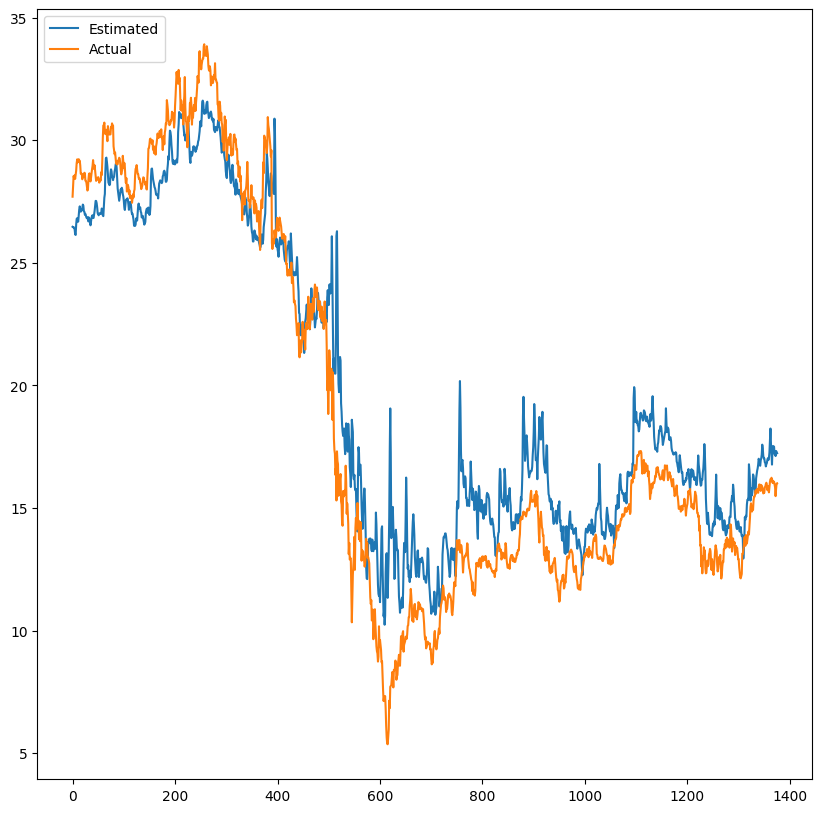

In [13]:
plt.figure()
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(Yval, BATCH_SIZE), (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')

## Changing Hyperparameters
Keras comes with pre-implemented loss functions and optimizers:

- Loss Function => https://keras.io/losses/
- Optimizer     => https://keras.io/optimizers/
         
I picked two loss functions and two optimizers (for a total of four combinations) and compared their results using 10 epochs.





| Optimizer | Loss | Observations|
|-----------|------|-------------|
| AdamW | MAE | The model demonstrated a reasonable ability to capture the overall trend of the data, particularly in smoother regions. However, it exhibited limitations in responding to sudden fluctuations, often lagging behind during sharp transitions. This can be attributed to the nature of Mean Absolute Error (MAE), which treats all deviations linearly and lacks sensitivity to larger errors. While AdamW’s adaptive learning provided stable convergence, the combination ultimately resulted in predictions that were somewhat over-smoothed and less reactive to volatility. This setup may be suitable for datasets with fewer abrupt changes but falls short in highly dynamic environments. |
| AdamW | Huber Loss | This model delivered a near-ideal fit to the actual data, clearly outperforming the others in both stability and accuracy. The predicted values closely followed the real trends, including during sharp reversals and high-volatility segments. The Huber loss function offered a balanced approach by behaving like MAE for outliers and MSE for smaller errors, effectively managing both noise and precision. When combined with AdamW’s adaptive updates and regularization through weight decay, the model maintained generalization without sacrificing responsiveness. This configuration showed the strongest alignment with actual stock values and is highly recommended for scenarios requiring both robustness and precision. |
| RMSprop | MAE | This configuration showed improved performance, where the model could pick up meaningful patterns within the data. It still lagged behind true values by a bit, particularly where there were sharp trend reversals. Blending RMSprop with the low-gradient behavior of the MAE loss function would likely lead to unstable and inconsistent learning. This resulted in the training set as well as validation set being underfit and fail to generalize to unseen data. In general, I don't think this setting was suitable for time series forecasting and should not be applied to such prediction problems. |
| RMSprop | Huber Loss | This pairing also yielded strong results, with the model accurately capturing key fluctuations and general patterns in the data. Predictions were smooth yet responsive, especially in areas with moderate volatility. The use of Huber loss provided robustness to outliers, while RMSprop’s gradient adaptation helped in reacting to recent changes. However, compared to AdamW with Huber, the fit was slightly less tight, particularly in certain sharp transitions. Nonetheless, this combination remains a strong candidate for modeling time series with variable dynamics, offering a good trade-off between performance and computational efficiency. |

I selected these specific optimizers and loss functions based on the nature of the data and the goal of achieving a balance between accuracy, robustness, and adaptability. Stock market data is inherently noisy, with frequent sharp movements and occasional outliers. Therefore, I wanted to test loss functions that could handle both stable and volatile segments effectively. MAE was chosen for its simplicity and resistance to outliers, while Huber Loss was included as a more flexible alternative that adapts based on the magnitude of the error.

On the optimizer side, I selected AdamW for its proven performance in handling sparse gradients and overfitting due to its weight decay, which often leads to better generalization. RMSprop, on the other hand, is known for its ability to quickly adapt to changing gradients, which I thought might be beneficial in time-series data where recent trends can shift abruptly. By testing these combinations, I aimed to identify a configuration that could generalize well, remain stable during training, and most importantly, produce predictions that closely align with real-world financial patterns.




# Optimizer - AdamW and Loss Function - Mean Absolute Error

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0499 - mae: 0.0499 - val_loss: 0.0421 - val_mae: 0.0421
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0200 - val_mae: 0.0200
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0201 - val_mae: 0.0201
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.0184 - val_mae: 0.0184
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0240 - val_mae: 0.0240
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0140 - mae: 0.0140 - val_loss: 0.0300 - val_mae: 0.0300
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0139 - mae: 0.0139 - val_loss: 0.0364 - val_mae: 0.0364
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0135 - mae: 0.0135 - val_loss: 0.0265 - val_mae: 0.0265
Epoch 9/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - lo

array([[0.55243045],
       [0.5563238 ],
       [0.55732745],
       ...,
       [0.3291626 ],
       [0.33156022],
       [0.33069646]], dtype=float32)

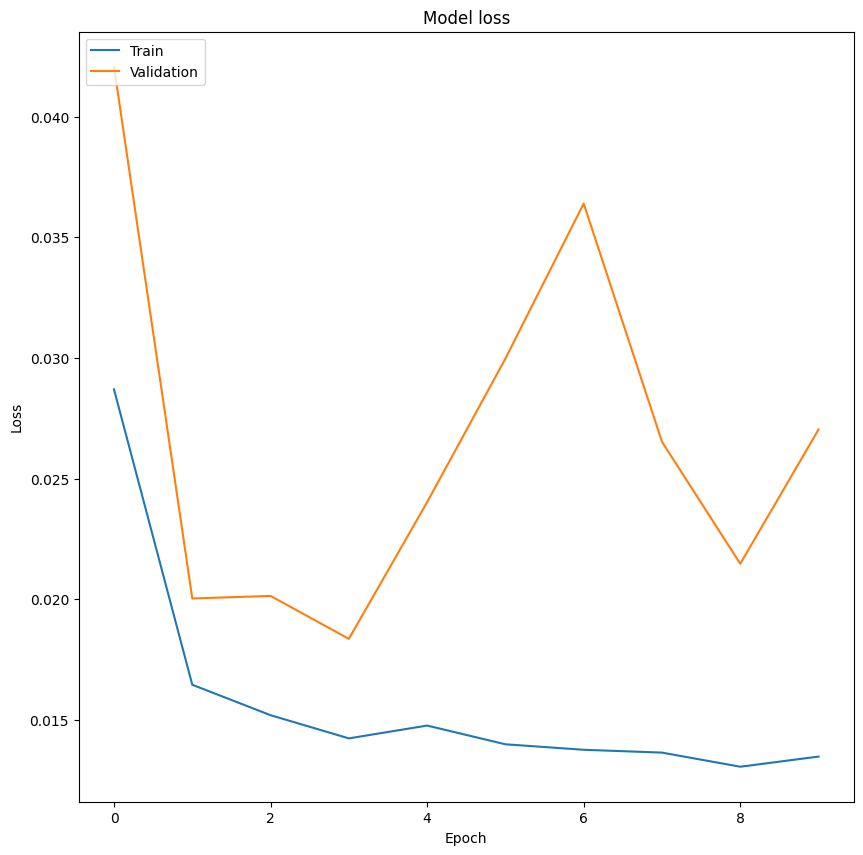

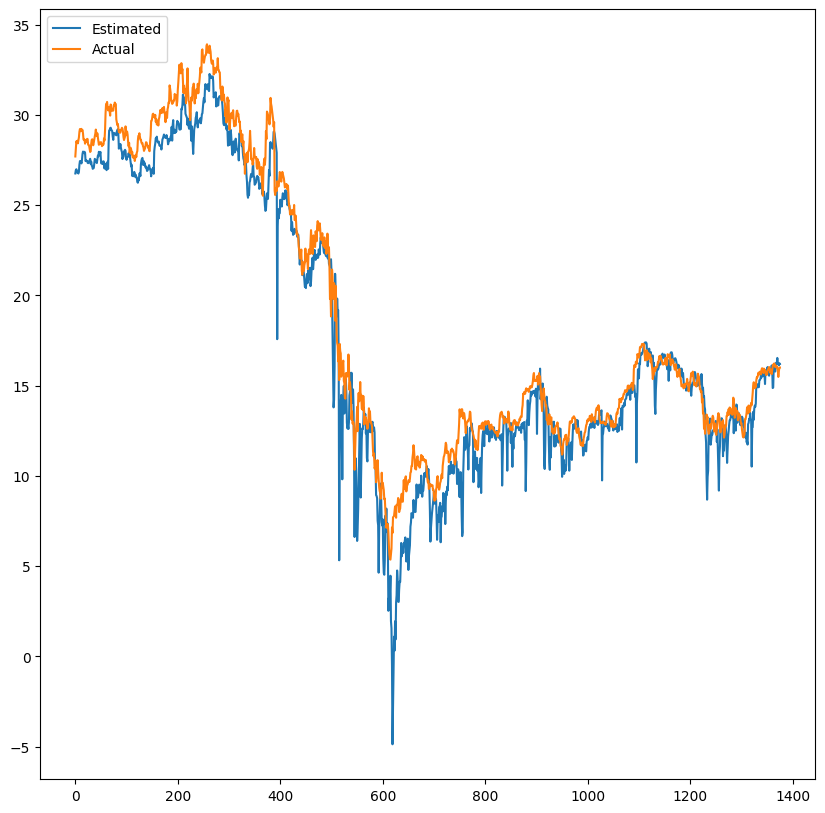

In [14]:
# Import functions from Keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, InputLayer
lstm_model = Sequential()
lstm_model.add(InputLayer(batch_input_shape = (BATCH_SIZE, TIME_STEPS, 
                                            x_t.shape[2])))
lstm_model.add(LSTM(100, stateful = True, dropout=0.0, recurrent_dropout=0.0))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='linear'))
lstm_model.compile(loss='mae', 
                   optimizer='adamw',
                   metrics=['mae'])

history = lstm_model.fit(x_t, y_t,
          batch_size=32, epochs=10, verbose=1,
          validation_data=(trim_dataset(Xval, BATCH_SIZE), 
                           trim_dataset(Yval, BATCH_SIZE)))

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

predicted = lstm_model.predict(trim_dataset(Xval, BATCH_SIZE))
display(predicted)

plt.figure()
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(Yval, BATCH_SIZE), (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')

# Optimizer - Root Mean Square Propagation and Loss Function - Mean Absolute Error

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0503 - mae: 0.0503 - val_loss: 0.0262 - val_mae: 0.0262
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0176 - mae: 0.0176 - val_loss: 0.0265 - val_mae: 0.0265
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0223 - val_mae: 0.0223
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0226 - val_mae: 0.0226
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0140 - mae: 0.0140 - val_loss: 0.0142 - val_mae: 0.0142
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0142 - mae: 0.0142 - val_loss: 0.0206 - val_mae: 0.0206
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0139 - mae: 0.0139 - val_loss: 0.0321 - val_mae: 0.0321
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0181 - val_mae: 0.0181
Epoch 9/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - lo

array([[0.5733376 ],
       [0.5746788 ],
       [0.5748867 ],
       ...,
       [0.34082296],
       [0.34150288],
       [0.34043625]], dtype=float32)

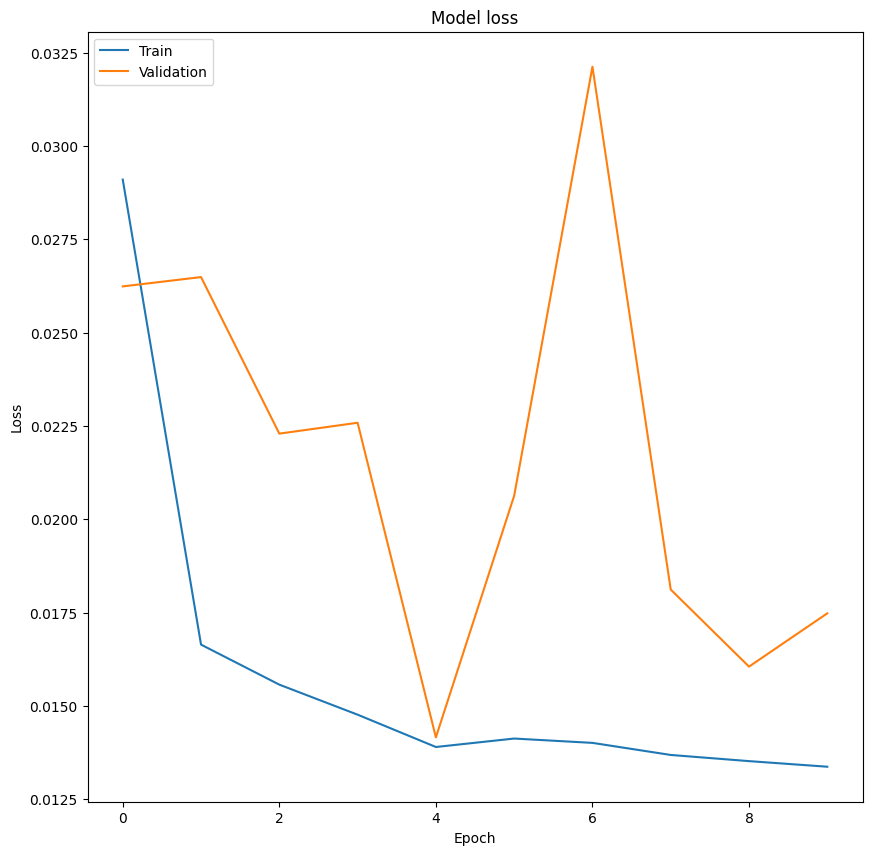

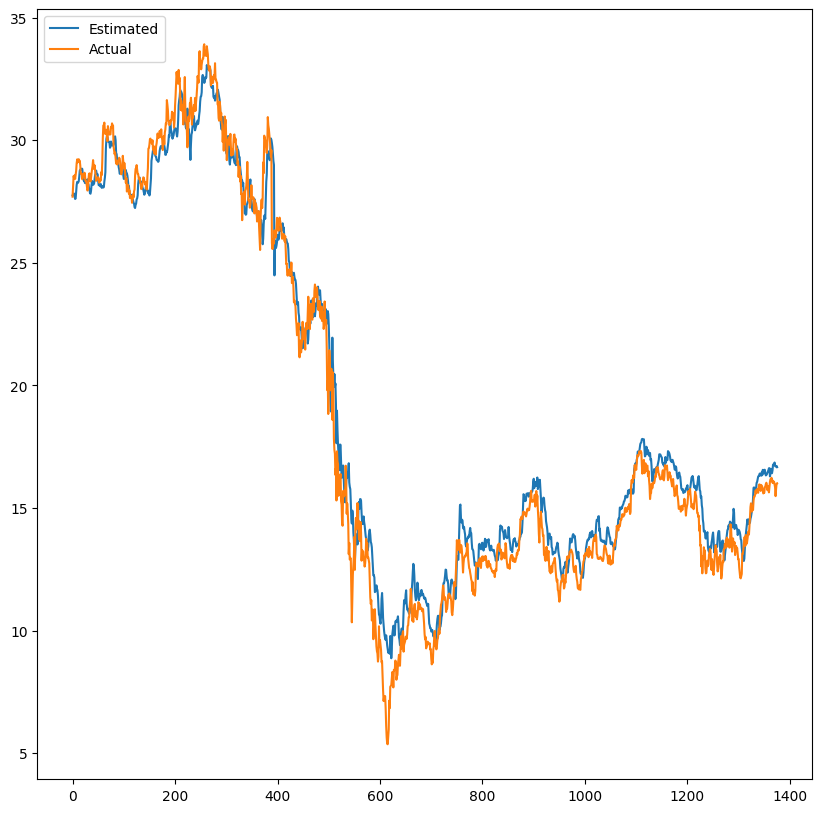

In [15]:
# Import functions from Keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, InputLayer
lstm_model = Sequential()
lstm_model.add(InputLayer(batch_input_shape = (BATCH_SIZE, TIME_STEPS, 
                                            x_t.shape[2])))
lstm_model.add(LSTM(100, stateful = True, dropout=0.0, recurrent_dropout=0.0))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='linear'))
lstm_model.compile(loss='mae', 
                   optimizer='rmsprop',
                   metrics=['mae'])

history = lstm_model.fit(x_t, y_t,
          batch_size=32, epochs=10, verbose=1,
          validation_data=(trim_dataset(Xval, BATCH_SIZE), 
                           trim_dataset(Yval, BATCH_SIZE)))

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

predicted = lstm_model.predict(trim_dataset(Xval, BATCH_SIZE))
display(predicted)

plt.figure()
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(Yval, BATCH_SIZE), (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')

# Optimizer - AdamW and Loss Function - Huber Loss

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0055 - mae: 0.0553 - val_loss: 9.1068e-04 - val_mae: 0.0277
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.7086e-04 - mae: 0.0188 - val_loss: 3.4951e-04 - val_mae: 0.0184
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.2808e-04 - mae: 0.0163 - val_loss: 3.9619e-04 - val_mae: 0.0207
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.8419e-04 - mae: 0.0159 - val_loss: 3.0500e-04 - val_mae: 0.0185
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.7140e-04 - mae: 0.0161 - val_loss: 5.4625e-04 - val_mae: 0.0250
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.5494e-04 - mae: 0.0162 - val_loss: 5.0946e-04 - val_mae: 0.0252
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.1821e-04 - mae: 0.0156 - val_loss: 4.5714e-04 - val_mae: 0.0231
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.2540e-04 - mae: 0.0157 - val_loss: 3.8372e-04 - val_mae: 0.0

array([[0.5486057 ],
       [0.55045545],
       [0.55067575],
       ...,
       [0.33212867],
       [0.3325675 ],
       [0.3316306 ]], dtype=float32)

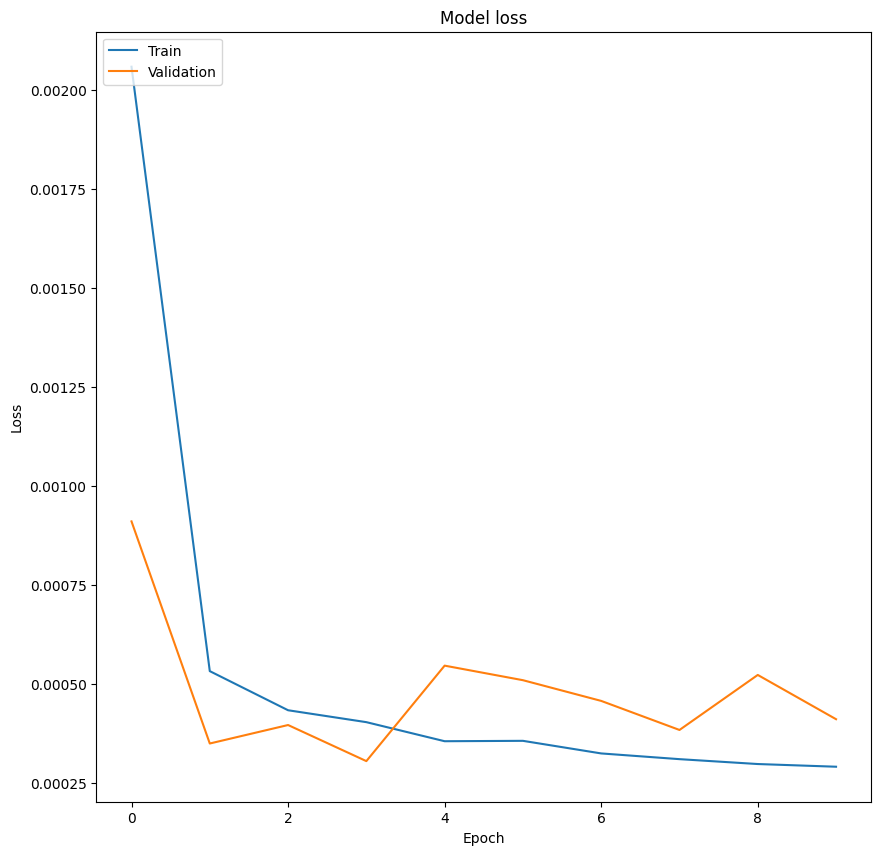

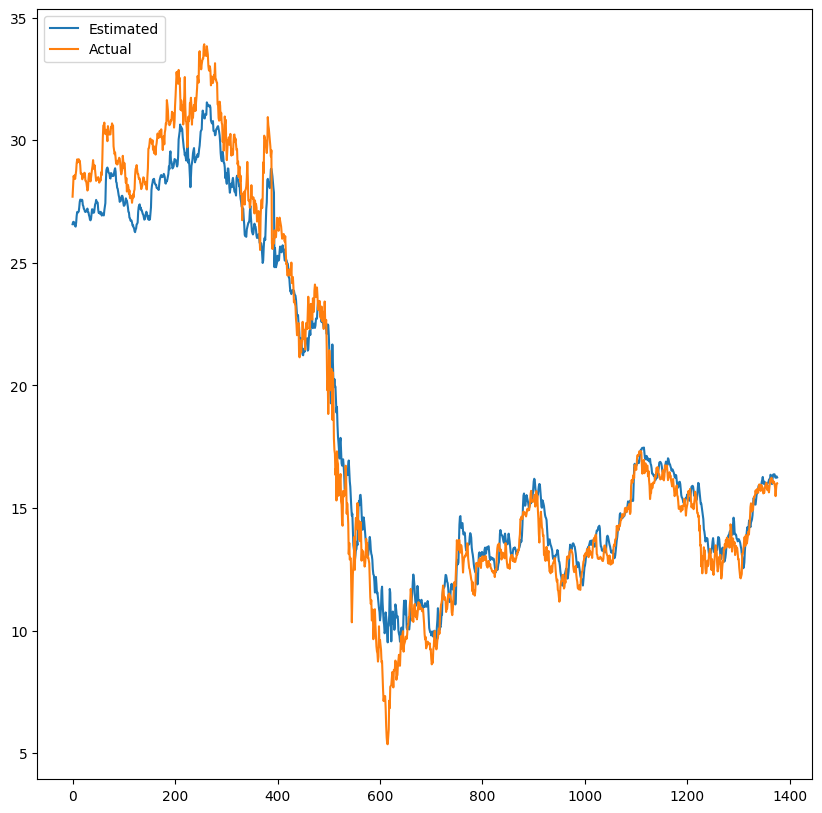

In [22]:
# Import functions from Keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, InputLayer
from tensorflow.keras.losses import Huber
lstm_model = Sequential()
lstm_model.add(InputLayer(batch_input_shape = (BATCH_SIZE, TIME_STEPS, 
                                            x_t.shape[2])))
lstm_model.add(LSTM(100, stateful = True, dropout=0.0, recurrent_dropout=0.0))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='linear'))
lstm_model.compile(loss=Huber(), 
                   optimizer='adamw',
                   metrics=['mae'])

history = lstm_model.fit(x_t, y_t,
          batch_size=32, epochs=10, verbose=1,
          validation_data=(trim_dataset(Xval, BATCH_SIZE), 
                           trim_dataset(Yval, BATCH_SIZE)))

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

predicted = lstm_model.predict(trim_dataset(Xval, BATCH_SIZE))
display(predicted)

plt.figure()
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(Yval, BATCH_SIZE), (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')

# Optimizer - Root Mean Square Propagation and Loss Function - Huber Loss

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0098 - mae: 0.0761 - val_loss: 0.0013 - val_mae: 0.0414
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.9108e-04 - mae: 0.0205 - val_loss: 4.7884e-04 - val_mae: 0.0245
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.8738e-04 - mae: 0.0191 - val_loss: 4.0162e-04 - val_mae: 0.0221
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.2717e-04 - mae: 0.0177 - val_loss: 4.1746e-04 - val_mae: 0.0216
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.9186e-04 - mae: 0.0172 - val_loss: 3.2193e-04 - val_mae: 0.0198
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.0147e-04 - mae: 0.0172 - val_loss: 4.9426e-04 - val_mae: 0.0238
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.6617e-04 - mae: 0.0166 - val_loss: 2.7832e-04 - val_mae: 0.0178
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.3083e-04 - mae: 0.0164 - val_loss: 2.4972e-04 - val_mae: 0.0164


array([[0.55813575],
       [0.5582833 ],
       [0.5572858 ],
       ...,
       [0.33527443],
       [0.33523053],
       [0.33346182]], dtype=float32)

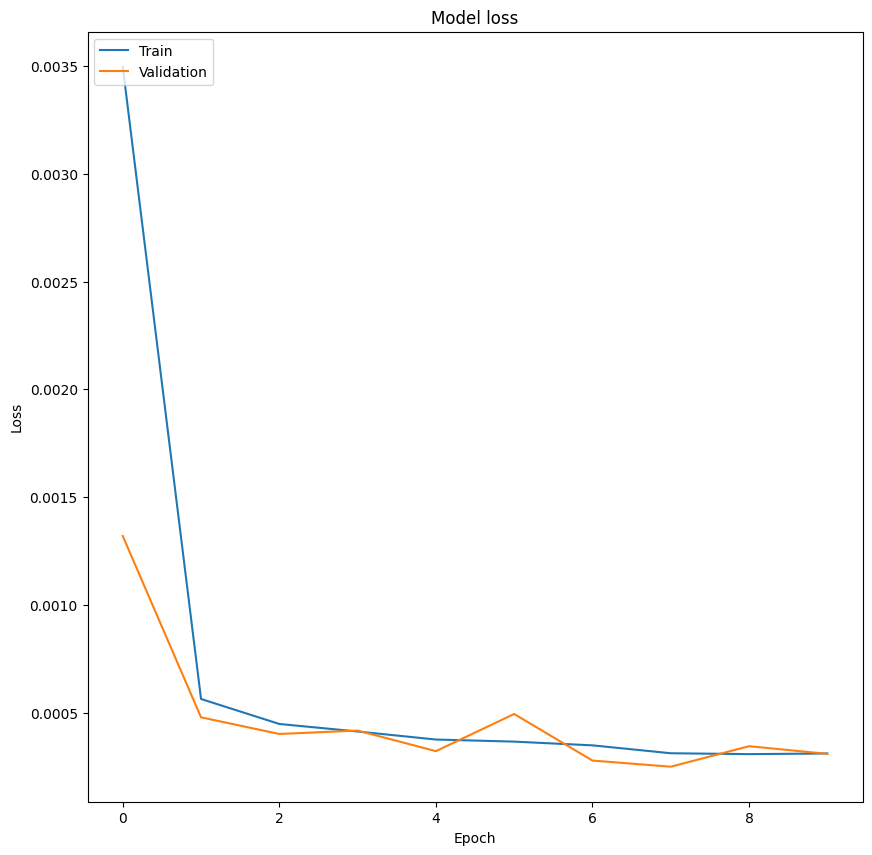

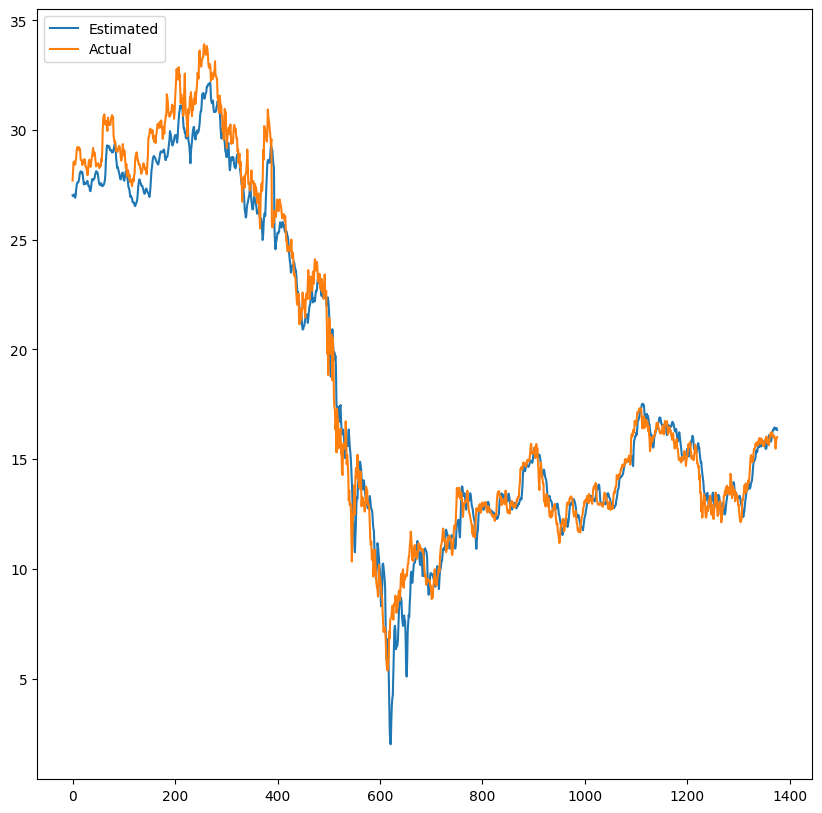

In [17]:
# Import functions from Keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, InputLayer
lstm_model = Sequential()
lstm_model.add(InputLayer(batch_input_shape = (BATCH_SIZE, TIME_STEPS, x_t.shape[2])))
lstm_model.add(LSTM(100, stateful = True, dropout=0.0, recurrent_dropout=0.0))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='linear'))
lstm_model.compile(loss=Huber(), 
                   optimizer='rmsprop',
                   metrics=['mae'])

history = lstm_model.fit(x_t, y_t,
          batch_size=32, epochs=10, verbose=1,
          validation_data=(trim_dataset(Xval, BATCH_SIZE), 
                           trim_dataset(Yval, BATCH_SIZE)))

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

predicted = lstm_model.predict(trim_dataset(Xval, BATCH_SIZE))
display(predicted)

plt.figure()
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(Yval, BATCH_SIZE), (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')

# Create Our Own Stock Prediction Algorithm

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


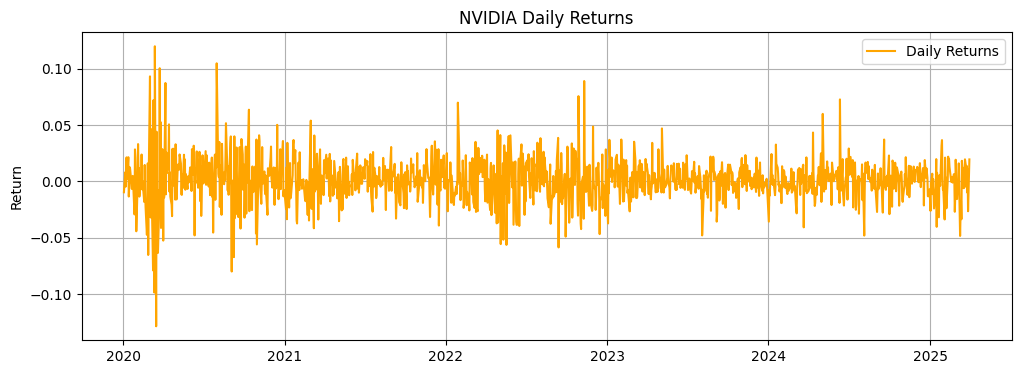

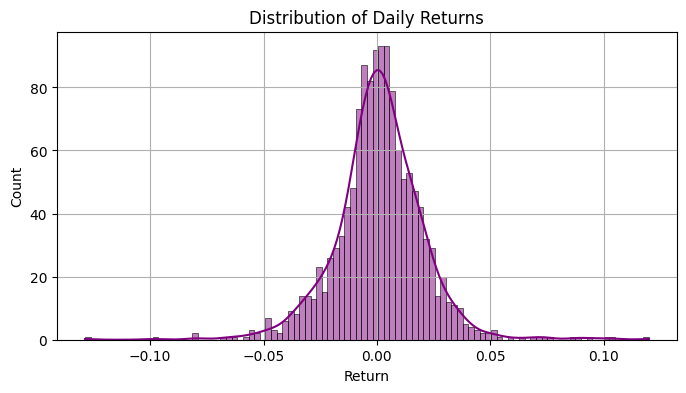

<Figure size 1000x500 with 0 Axes>

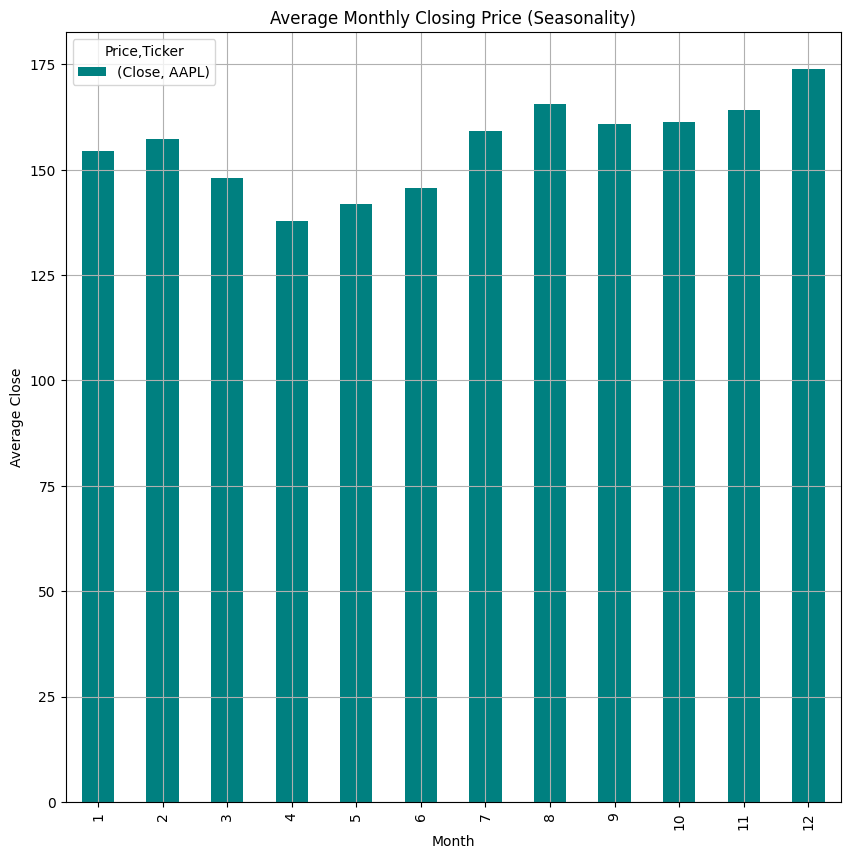

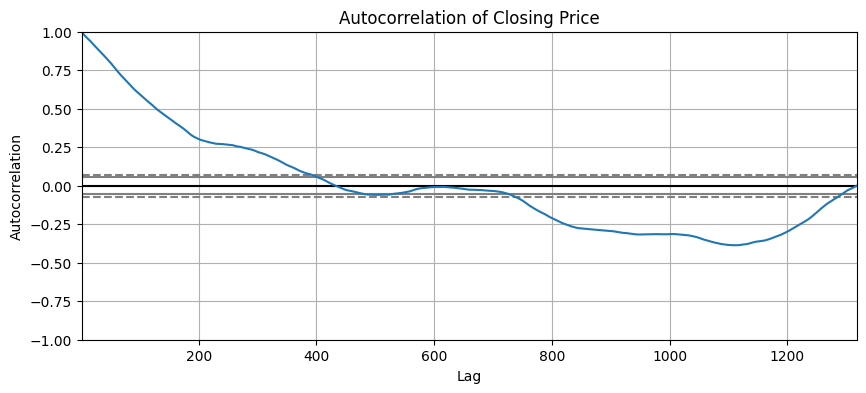

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

data = yf.download("AAPL", start="2020-01-01", end="2025-04-01")
data.dropna(inplace=True)

data['Return'] = data['Close'].pct_change()
plt.figure(figsize=(12, 4))
plt.plot(data['Return'], label='Daily Returns', color='orange')
plt.title("NVIDIA Daily Returns")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(data['Return'].dropna(), bins=100, kde=True, color='purple')
plt.title("Distribution of Daily Returns")
plt.xlabel("Return")
plt.grid(True)
plt.show()

data['Month'] = data.index.month
monthlyavg = data.groupby('Month')['Close'].mean()

plt.figure(figsize=(10, 5))
monthlyavg.plot(kind='bar', color='teal')
plt.title("Average Monthly Closing Price (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Average Close")
plt.grid(True)
plt.show()

from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(10, 4))
autocorrelation_plot(data['Close'])
plt.title("Autocorrelation of Closing Price")
plt.grid(True)
plt.show()

# Approach One - Predicting Everything at once (30 days window and 365 days window)

[*********************100%***********************]  1 of 1 completed
C:\Users\pooja\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.1347 - val_loss: 0.1837 - learning_rate: 5.0000e-04
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0680 - val_loss: 0.0604 - learning_rate: 5.0000e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0234 - val_loss: 0.0143 - learning_rate: 5.0000e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0089 - val_loss: 0.0077 - learning_rate: 5.0000e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0062 - val_loss: 0.0081 - learning_rate: 5.0000e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0054 - val_loss: 0.0079 - learning_rate: 5.0000e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0053 - val_loss: 0.0075 - learning_rate: 5.0000e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0051 - val_loss: 0.0077 - learning_rate: 5.0000e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0050 - val_loss: 0.0079 

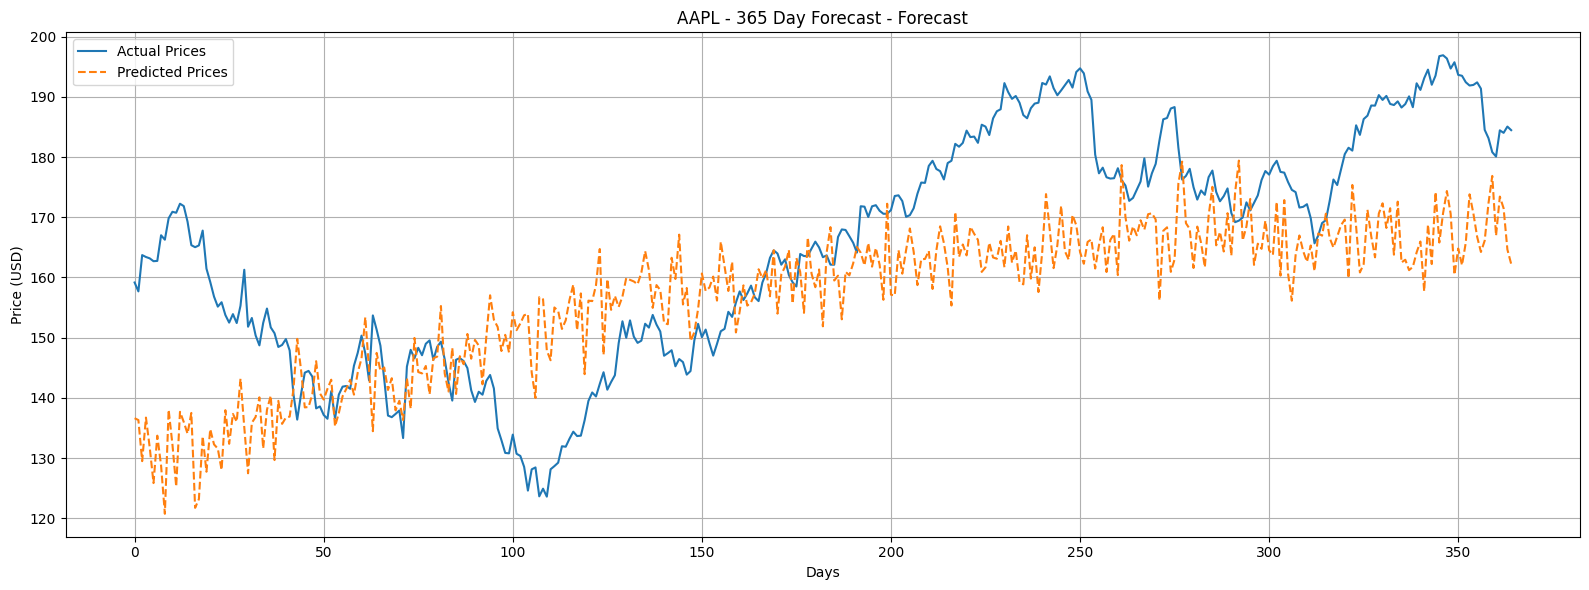

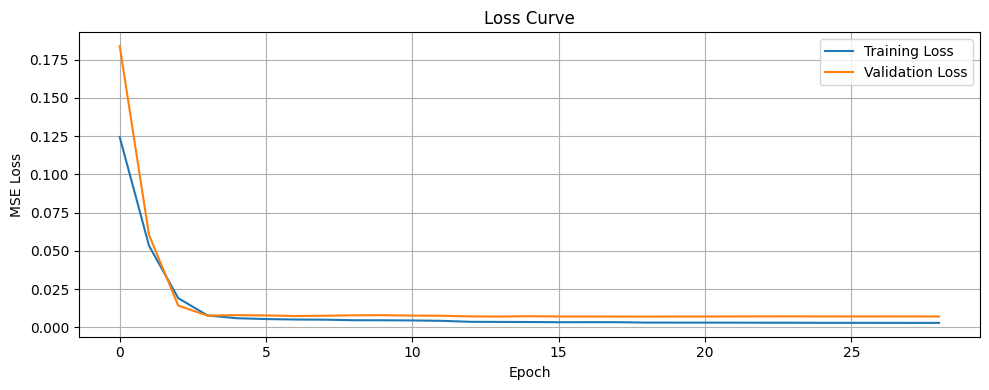

Root Mean Squared Error (RMSE): 28.80
Mean Absolute Error (MAE): 23.85
Mean Absolute Percentage Error (MAPE): 12.71%


C:\Users\pooja\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0837 - val_loss: 0.0461 - learning_rate: 5.0000e-04
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0143 - val_loss: 0.0099 - learning_rate: 5.0000e-04
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0038 - val_loss: 0.0094 - learning_rate: 5.0000e-04
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0030 - val_loss: 0.0066 - learning_rate: 5.0000e-04
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0026 - val_loss: 0.0084 - learning_rate: 5.0000e-04
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0024 - val_loss: 0.0057 - learning_rate: 5.0000e-04
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0024 - val_loss: 0.0068 - learning_rate: 5.0000e-04
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0022 - val_loss: 0.0062 - learning_rate: 5.0000e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0023 - val_loss: 0.0055 - 

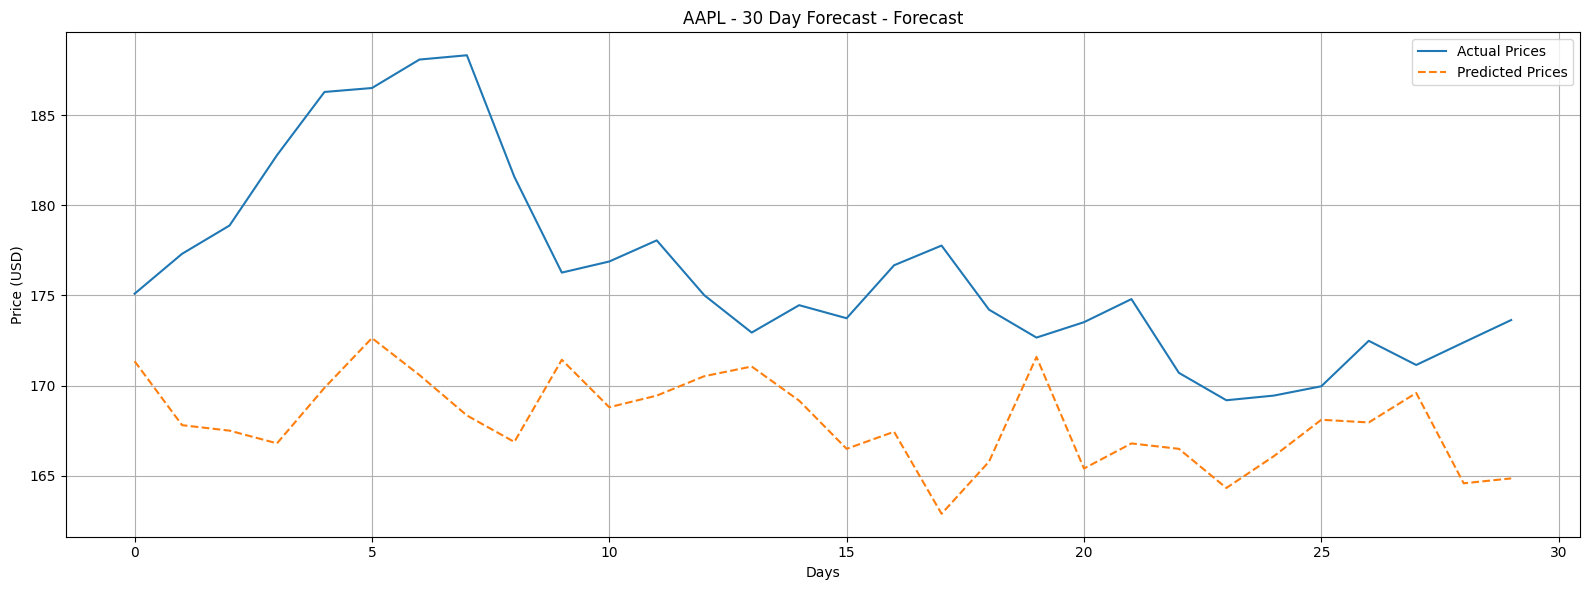

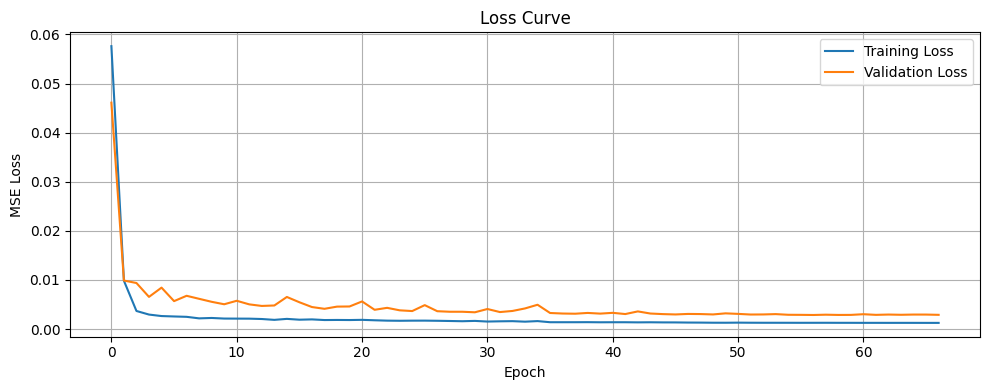

Root Mean Squared Error (RMSE): 23.13
Mean Absolute Error (MAE): 18.40
Mean Absolute Percentage Error (MAPE): 8.67%


In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import math

def loading(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    return df

def additionalIndicators(df):
    df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    pct_change = df['Close'].pct_change()
    df['RSI'] = 100 - (100 / (1 + pct_change.rolling(window=14).mean() / pct_change.rolling(window=14).std()))
    df = df.fillna(0)
    return df

def scaling(df):
    featureScaler = MinMaxScaler()
    closeScaler = MinMaxScaler()
    df['Close_Scaled'] = closeScaler.fit_transform(df[['Close']])
    indicators = featureScaler.fit_transform(df[['Log Return', 'SMA_50', 'SMA_200', 'RSI']])
    combined = np.hstack([df[['Close_Scaled']].values, indicators])
    return combined, closeScaler

def sequenceWindow(data, seq_length=90, forecastDays=365):
    X, Y = [], []
    for i in range(len(data) - seq_length - forecastDays):
        X.append(data[i:i+seq_length])
        Y.append(data[i+seq_length:i+seq_length+forecastDays, 0])
    return np.array(X), np.array(Y)

def modelBuilding(input_shape, output_steps):
    model = Sequential([
        LSTM(64, return_sequences=False, activation='tanh', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(output_steps, activation='linear')
    ])
    optimizer = RMSprop(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def plotingForecast(actual, predicted, ticker):
    plt.figure(figsize=(16, 6))
    plt.plot(actual[0], label='Actual Prices')
    plt.plot(predicted[0], label='Predicted Prices', linestyle='--')
    plt.title(f'{ticker} - Forecast')
    plt.xlabel('Days')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def losscurve(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate(actual, predicted):
    rmse = math.sqrt(mean_squared_error(actual.flatten(), predicted.flatten()))
    mae = mean_absolute_error(actual.flatten(), predicted.flatten())
    mape = np.mean(np.abs((actual.flatten() - predicted.flatten()) / actual.flatten())) * 100
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

ticker = 'AAPL'
start = '2018-01-01'
end = '2025-01-01'
seqlength = 180

df = loading(ticker, start, end)
df = additionalIndicators(df)
scaledData, closeScaler = scaling(df)

forecastDays = 365
X, Y = sequenceWindow(scaledData, seqlength, forecastDays)
split = int(0.8 * len(X))
Xtrain, Xtest = X[:split], X[split:]
Ytrain, Ytest = Y[:split], Y[split:]

model = modelBuilding((Xtrain.shape[1], Xtrain.shape[2]), forecastDays)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
history = model.fit(Xtrain, Ytrain, epochs=100, batch_size=32, validation_split=0.2, verbose=1,
                    callbacks=[early_stopping, reduce_lr])

predScaled = model.predict(Xtest)
pred = closeScaler.inverse_transform(predScaled)
actual = closeScaler.inverse_transform(Ytest)

plotingForecast(actual, pred, f"{ticker} - 365 Day Forecast")
losscurve(history)
evaluate(actual, pred)

model.save(f"{ticker}_365day_model_OneGo.h5")

forecastDays30 = 30
X30, Y30 = sequenceWindow(scaledData, seqlength, forecastDays30)
split30 = int(0.8 * len(X30))
Xtrain30, Xtest30 = X30[:split30], X30[split30:]
Ytrain30, Ytest30 = Y30[:split30], Y30[split30:]

model30 = modelBuilding((Xtrain30.shape[1], Xtrain30.shape[2]), forecastDays30)
historY30 = model30.fit(Xtrain30, Ytrain30, epochs=100, batch_size=32, validation_split=0.2, verbose=1,
                          callbacks=[early_stopping, reduce_lr])

predScaled30 = model30.predict(Xtest30)
pred30 = closeScaler.inverse_transform(predScaled30)
actual30 = closeScaler.inverse_transform(Ytest30)

plotingForecast(actual30, pred30, f"{ticker} - 30 Day Forecast")
losscurve(historY30)
evaluate(actual30, pred30)

model30.save(f"{ticker}_30day_model_OneGo.h5")
df.to_csv(f"{ticker}_dataset.csv")

[*********************100%***********************]  1 of 1 completed
C:\Users\pooja\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\pooja\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 767ms/step - loss: 0.1400 - val_loss: 0.2608 - learning_rate: 5.0000e-04
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 692ms/step - loss: 0.1085 - val_loss: 0.1413 - learning_rate: 5.0000e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 701ms/step - loss: 0.0594 - val_loss: 0.0761 - learning_rate: 5.0000e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 700ms/step - loss: 0.0401 - val_loss: 0.0668 - learning_rate: 5.0000e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 707ms/step - loss: 0.0273 - val_loss: 0.0157 - learning_rate: 5.0000e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 751ms/step - loss: 0.0156 - val_loss: 0.0107 - learning_rate: 5.0000e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 736ms/step - loss: 0.0137 - val_loss: 0.0098 - learning_rate: 5.0000e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 730ms/step - loss: 0.0130 - val_loss: 0.0084 - learning_rate: 5.0000e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 704ms/step - loss: 0.0118 - v

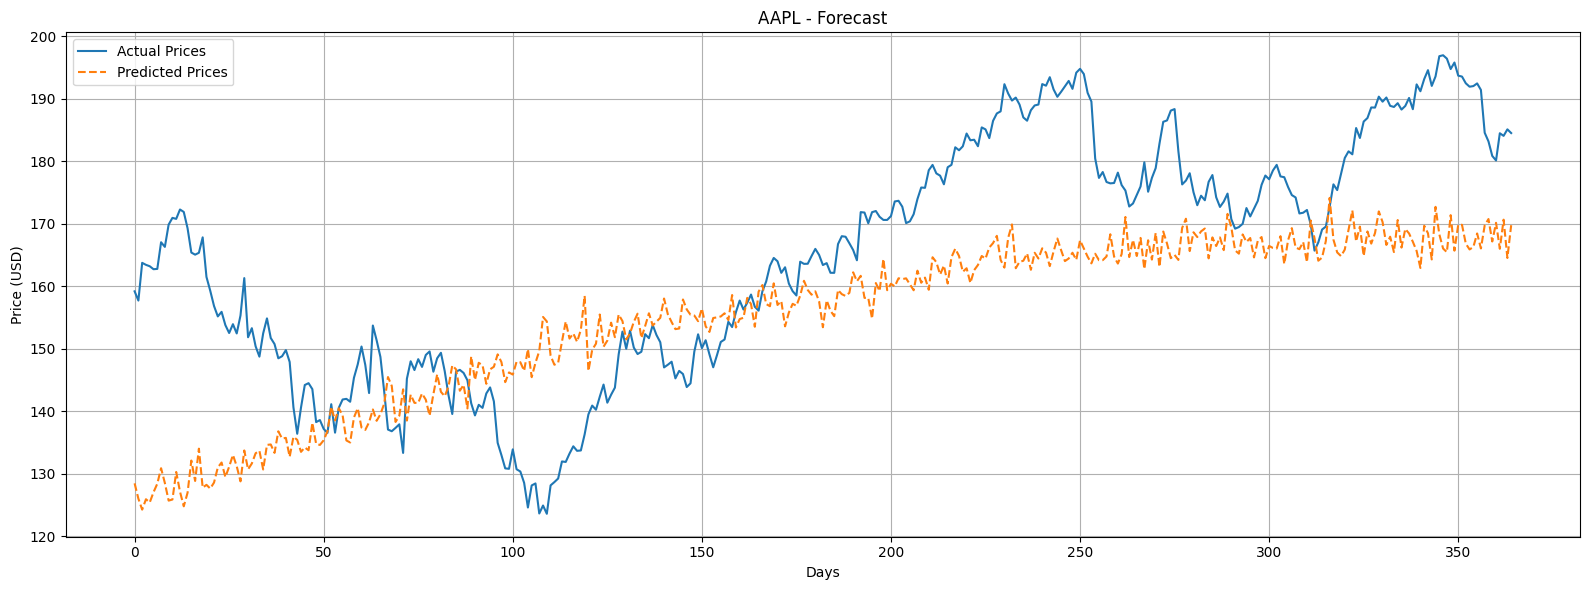

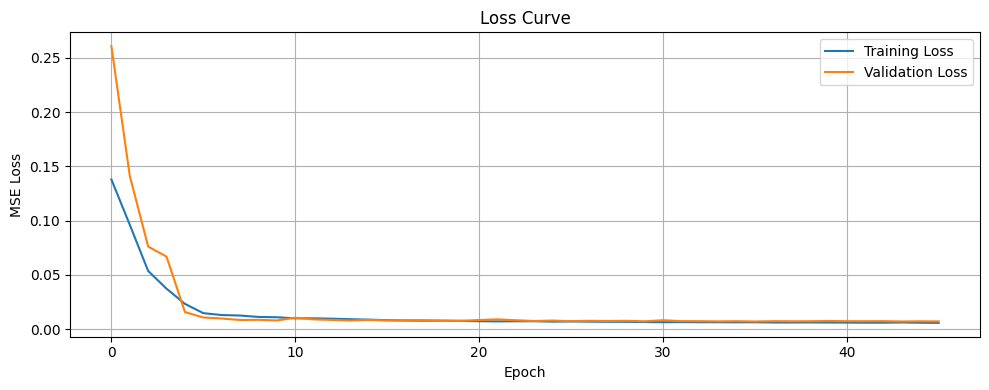

Root Mean Squared Error (RMSE): 29.54
Mean Absolute Error (MAE): 24.63
Mean Absolute Percentage Error (MAPE): 13.15%


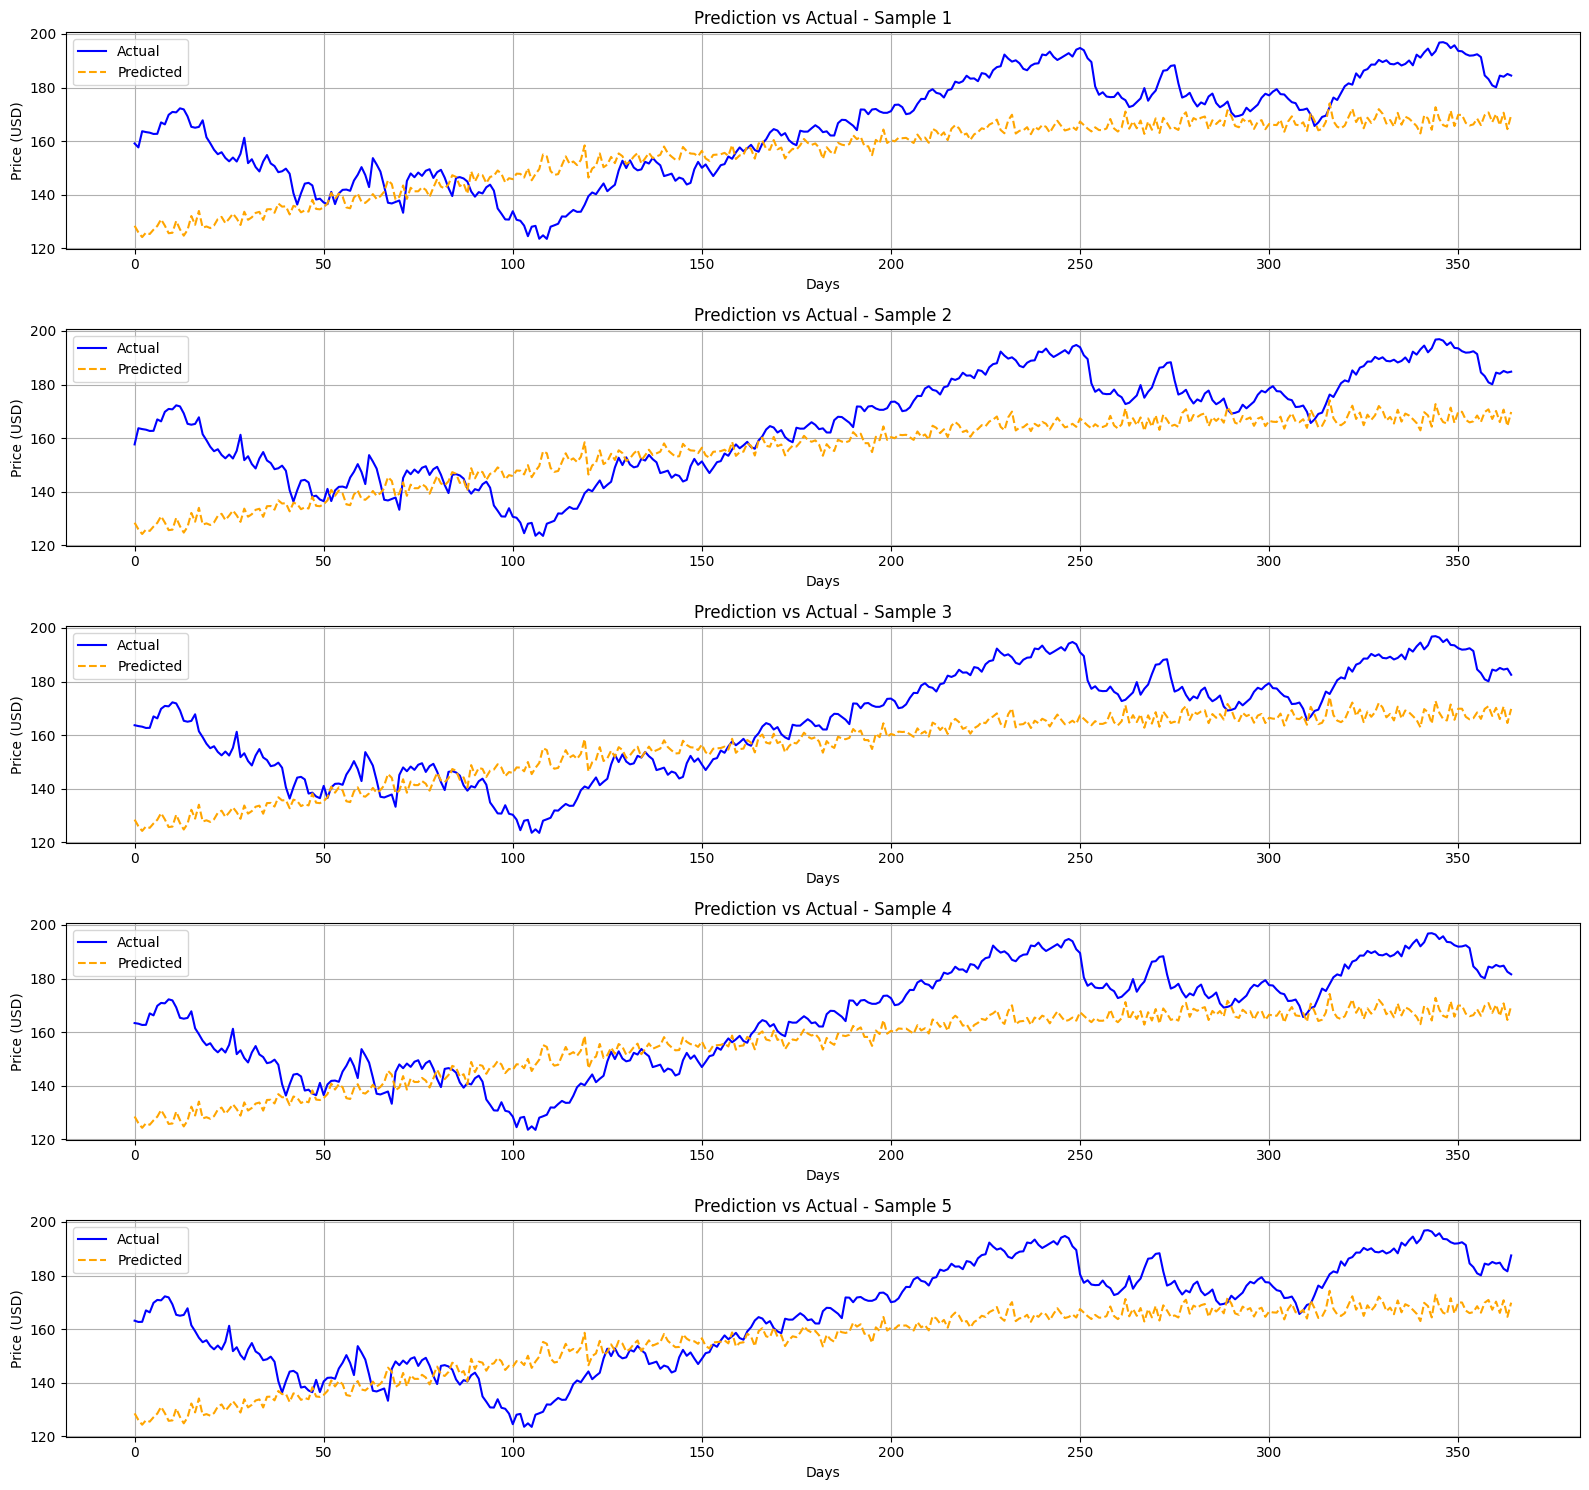

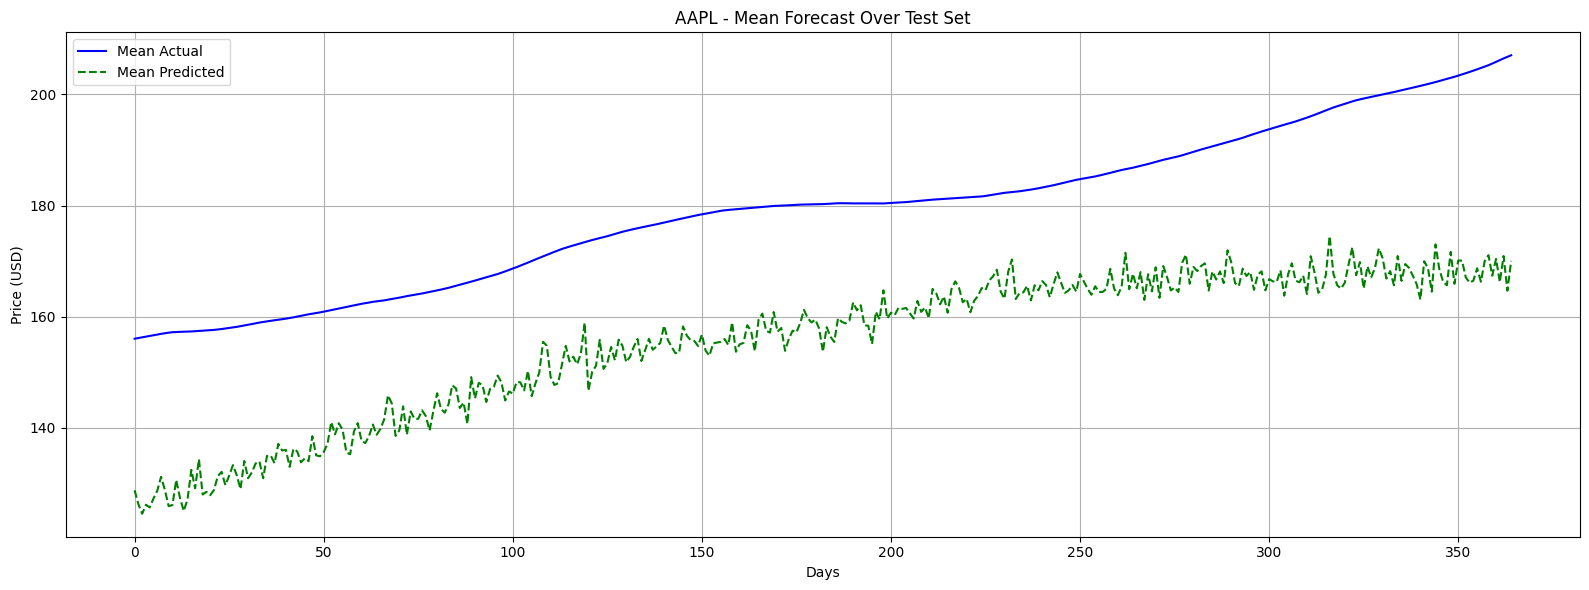

C:\Users\pooja\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\pooja\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 733ms/step - loss: 0.0964 - val_loss: 0.0727 - learning_rate: 5.0000e-04
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 680ms/step - loss: 0.0340 - val_loss: 0.0279 - learning_rate: 5.0000e-04
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - loss: 0.0207 - val_loss: 0.0124 - learning_rate: 5.0000e-04
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 681ms/step - loss: 0.0132 - val_loss: 0.0116 - learning_rate: 5.0000e-04
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 683ms/step - loss: 0.0104 - val_loss: 0.0075 - learning_rate: 5.0000e-04
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 683ms/step - loss: 0.0085 - val_loss: 0.0121 - learning_rate: 5.0000e-04
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 688ms/step - loss: 0.0089 - val_loss: 0.0078 - learning_rate: 5.0000e-04
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 653ms/step - loss: 0.0075 - val_loss: 0.0061 - learning_rate: 5.0000e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 650ms/step - loss: 0.0077 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step


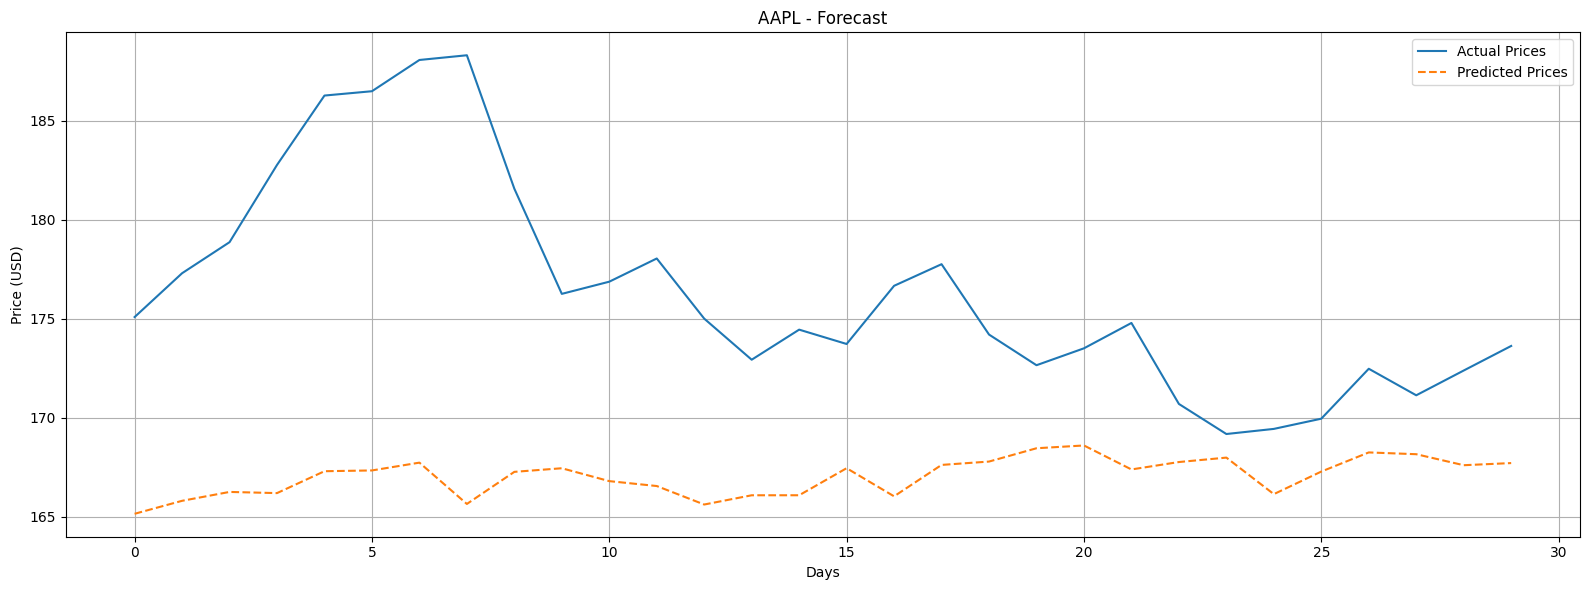

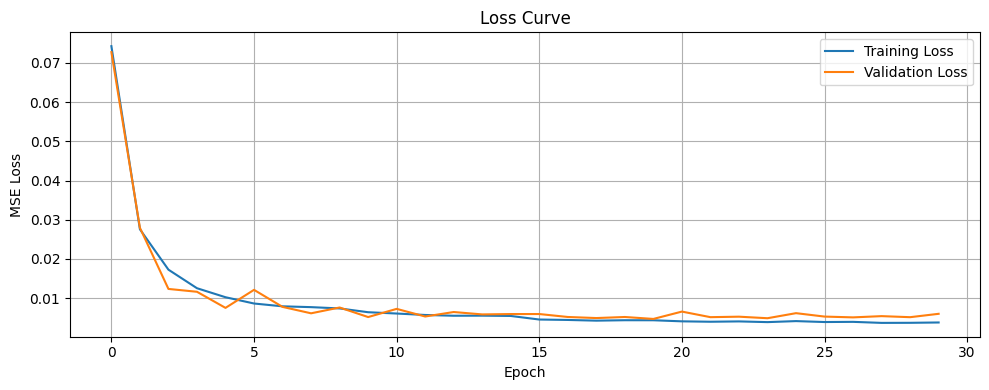

Root Mean Squared Error (RMSE): 31.65
Mean Absolute Error (MAE): 25.90
Mean Absolute Percentage Error (MAPE): 12.18%


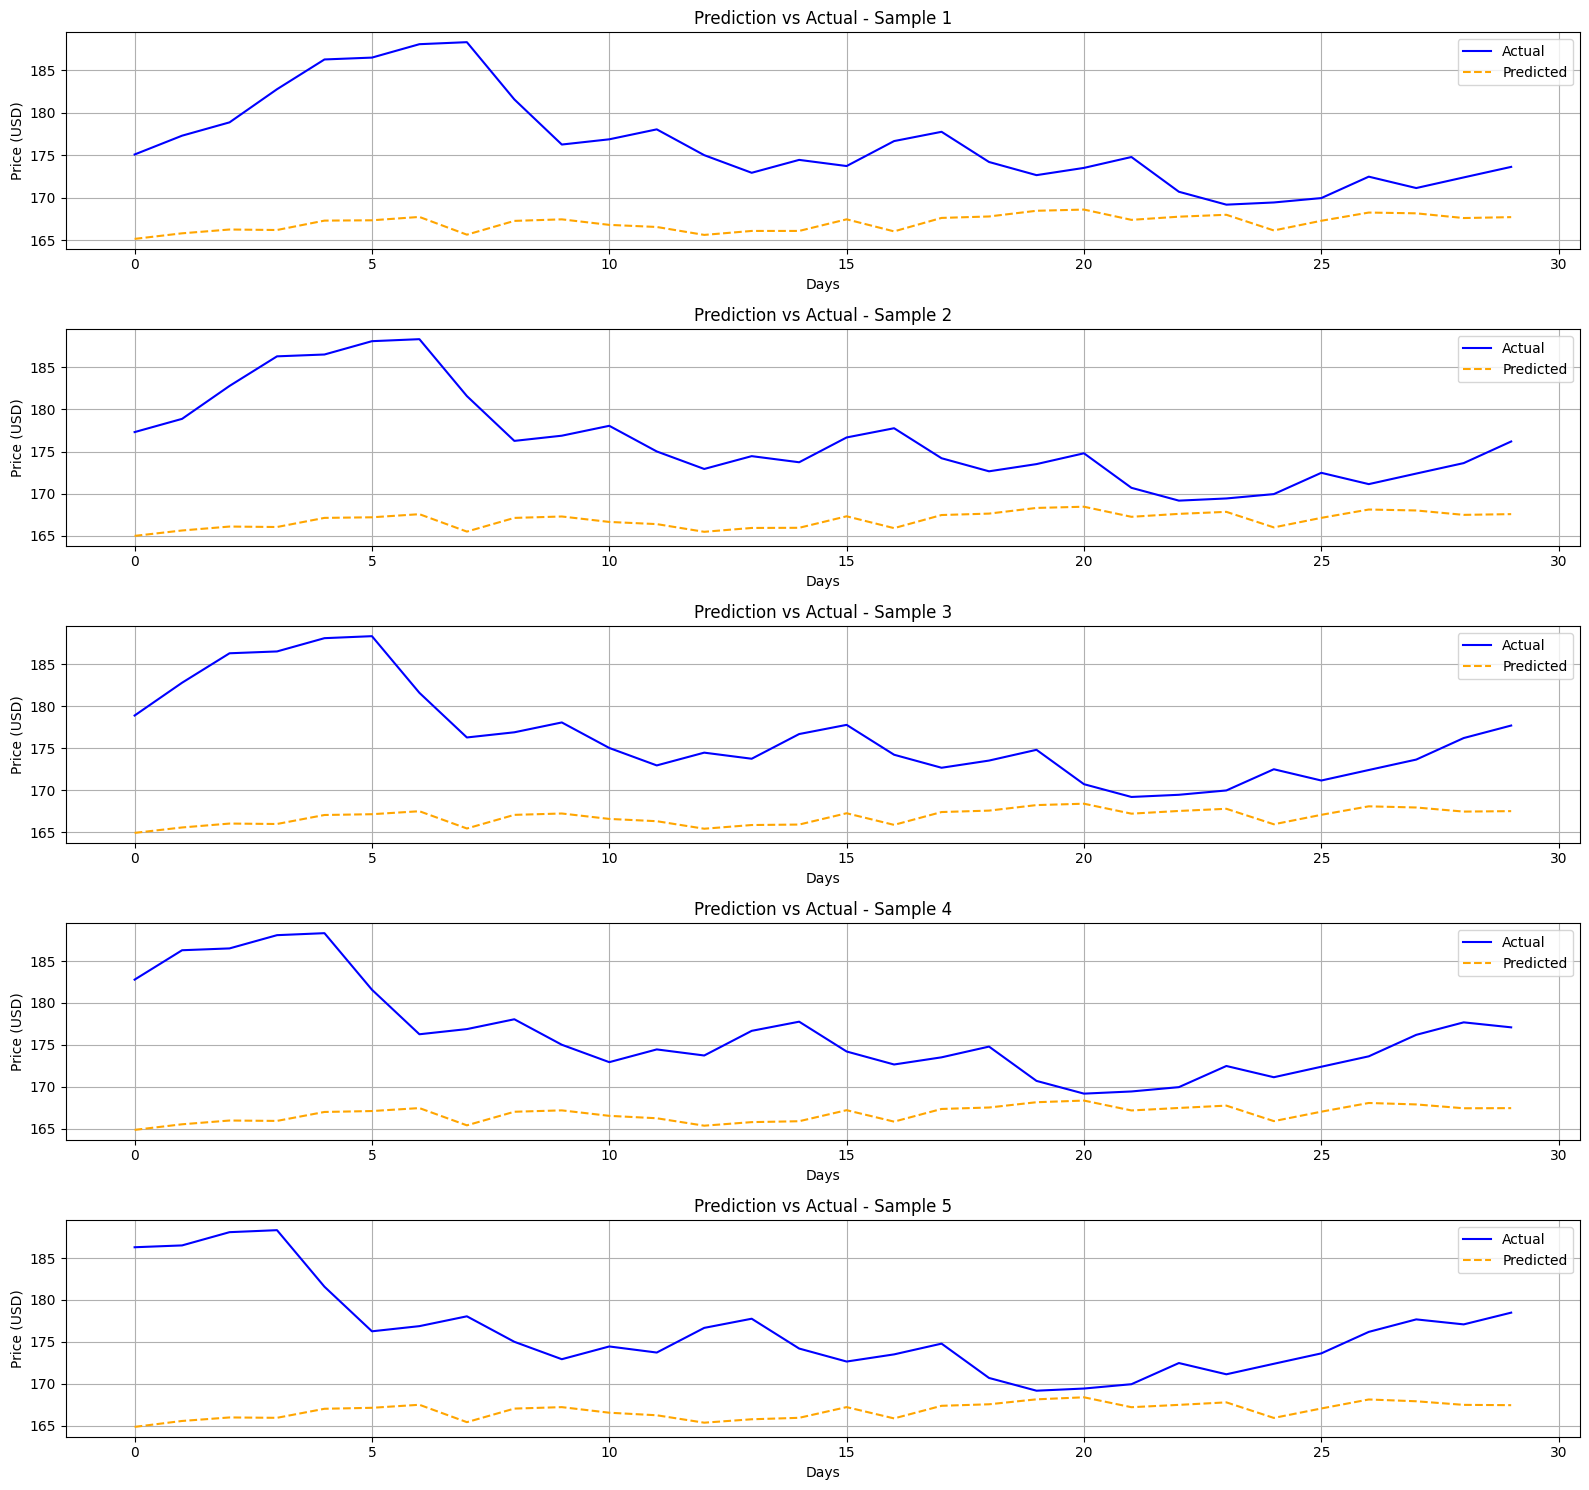

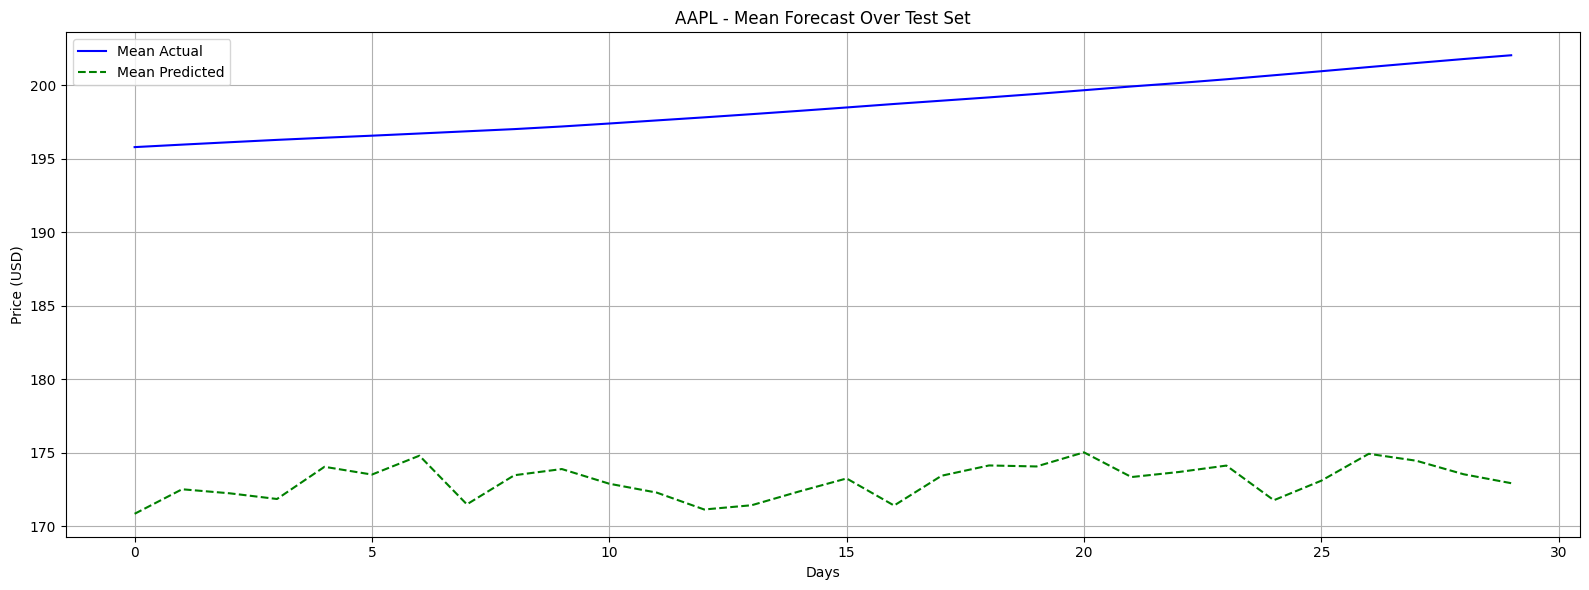

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import math

def buildingModel(input_shape, forecastDays):
    model = Sequential()
    
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.2))
    
    model.add(LSTM(128, return_sequences=True))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.3))
    
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.3))
    
    model.add(LSTM(64, return_sequences=False))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.2))
    
    model.add(Dense(forecastDays))
    
    return model

def plotingValidation(actual, predicted, n=5):
    plt.figure(figsize=(16, n * 3))
    for i in range(n):
        plt.subplot(n, 1, i + 1)
        plt.plot(actual[i], label='Actual', color='blue')
        plt.plot(predicted[i], label='Predicted', color='orange', linestyle='--')
        plt.title(f'Prediction vs Actual - Sample {i + 1}')
        plt.xlabel('Days')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

def plotMean(actual, predicted, ticker):
    meanActual = np.mean(actual, axis=0)
    meanPred = np.mean(predicted, axis=0)

    plt.figure(figsize=(16, 6))
    plt.plot(meanActual, label='Mean Actual', color='blue')
    plt.plot(meanPred, label='Mean Predicted', color='green', linestyle='--')
    plt.title(f'{ticker} - Mean Forecast Over Test Set')
    plt.xlabel('Days')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

ticker = 'AAPL'
start = '2018-01-01'
end = '2025-01-01'
seqlength = 180
forecastDays_365 = 365
forecastDays30 = 30

data = loading(ticker, start, end)
data = additionalIndicators(data)
scaledData, closeScaler = scaling(data)

X, Y = sequenceWindow(scaledData, seqlength, forecastDays_365)
split = int(0.8 * len(X))
Xtrain, Xtest = X[:split], X[split:]
Ytrain, Ytest = Y[:split], Y[split:]

model = buildingModel((Xtrain.shape[1], Xtrain.shape[2]), forecastDays_365)
model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(Xtrain, Ytrain, epochs=100, batch_size=32, validation_split=0.2, verbose=1,
                    callbacks=[early_stopping, reduce_lr])

predScaled_365 = model.predict(Xtest)
predicted_365 = closeScaler.inverse_transform(predScaled_365)
actual_365 = closeScaler.inverse_transform(Ytest)

plotingForecast(actual_365, predicted_365, ticker)
losscurve(history)
evaluate(actual_365, predicted_365)
plotingValidation(actual_365, predicted_365, n=5)
plotMean(actual_365, predicted_365, ticker)

model.save(f"{ticker}_365day_model_OneGo2.h5")

X30, Y30 = sequenceWindow(scaledData, seqlength, forecastDays30)
split30 = int(0.8 * len(X30))
Xtrain30, Xtest30 = X30[:split30], X30[split30:]
Ytrain30, Ytest30 = Y30[:split30], Y30[split30:]

model30 = buildingModel((Xtrain30.shape[1], Xtrain30.shape[2]), forecastDays30)
model30.compile(optimizer=RMSprop(learning_rate=0.0005), loss='mse')

historY30 = model30.fit(Xtrain30, Ytrain30, epochs=100, batch_size=32, validation_split=0.2, verbose=1,
                          callbacks=[early_stopping, reduce_lr])

predScaled30 = model30.predict(Xtest30)
predicted30 = closeScaler.inverse_transform(predScaled30)
actual30 = closeScaler.inverse_transform(Ytest30)

plotingForecast(actual30, predicted30, ticker)
losscurve(historY30)
evaluate(actual30, predicted30)
plotingValidation(actual30, predicted30, n=5)
plotMean(actual30, predicted30, ticker)

model30.save(f"{ticker}_30day_model_OneGo2.h5")

# Approach Two - Predicting Day by Day Recursively (Both 30 days and 365 days with the same model)

[*********************100%***********************]  1 of 1 completed
C:\Users\pooja\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 207ms/step - loss: 0.0051 - val_loss: 8.3800e-04
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - loss: 1.0022e-04 - val_loss: 8.5612e-04
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - loss: 1.1143e-04 - val_loss: 0.0010
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 201ms/step - loss: 1.2220e-04 - val_loss: 9.3552e-04
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - loss: 1.0279e-04 - val_loss: 6.3146e-04
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - loss: 1.0374e-04 - val_loss: 6.0423e-04
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - loss: 9.5454e-05 - val_loss: 5.8134e-04
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - loss: 9.6298e-05 - val_loss: 6.5302e-04
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - loss: 8.6101e-05 - val_loss: 6.1689e-04
Epoch 10/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step - loss: 1.1759e-04 - val_loss: 5.2170e-04
Epoch 11/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 201

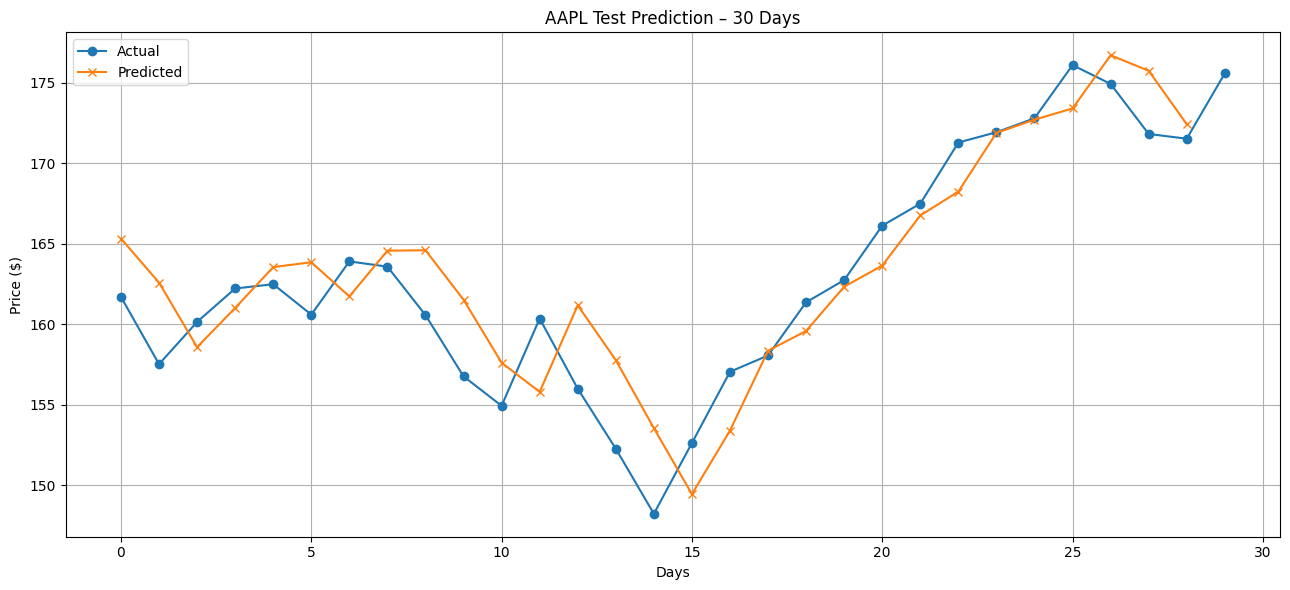

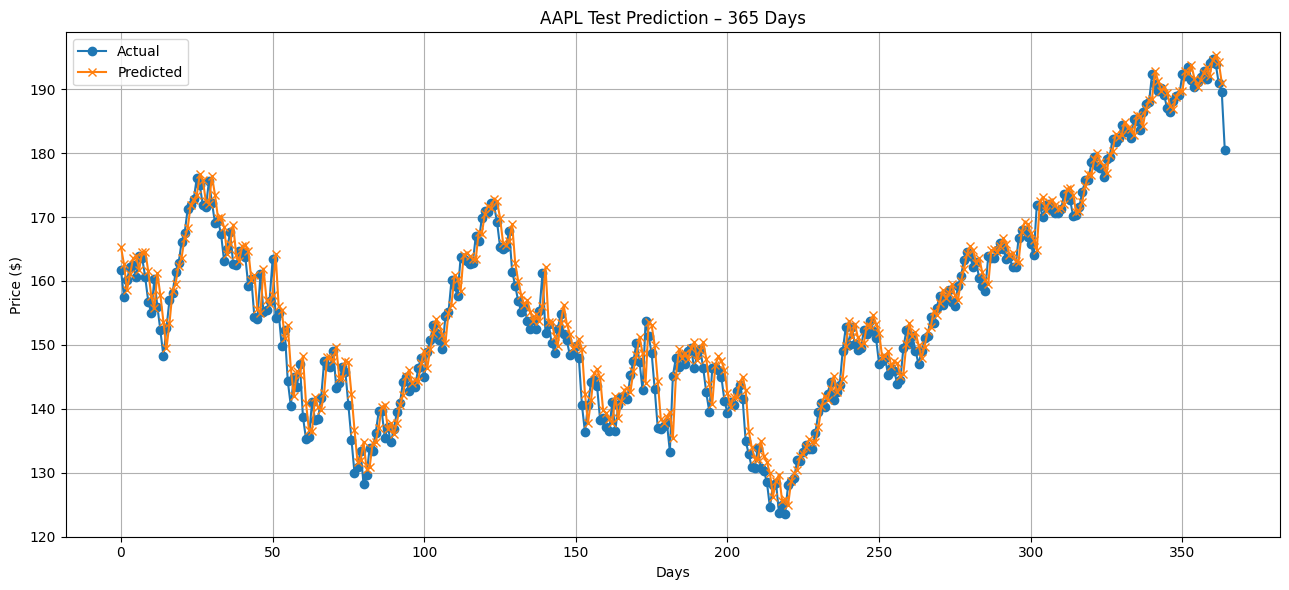

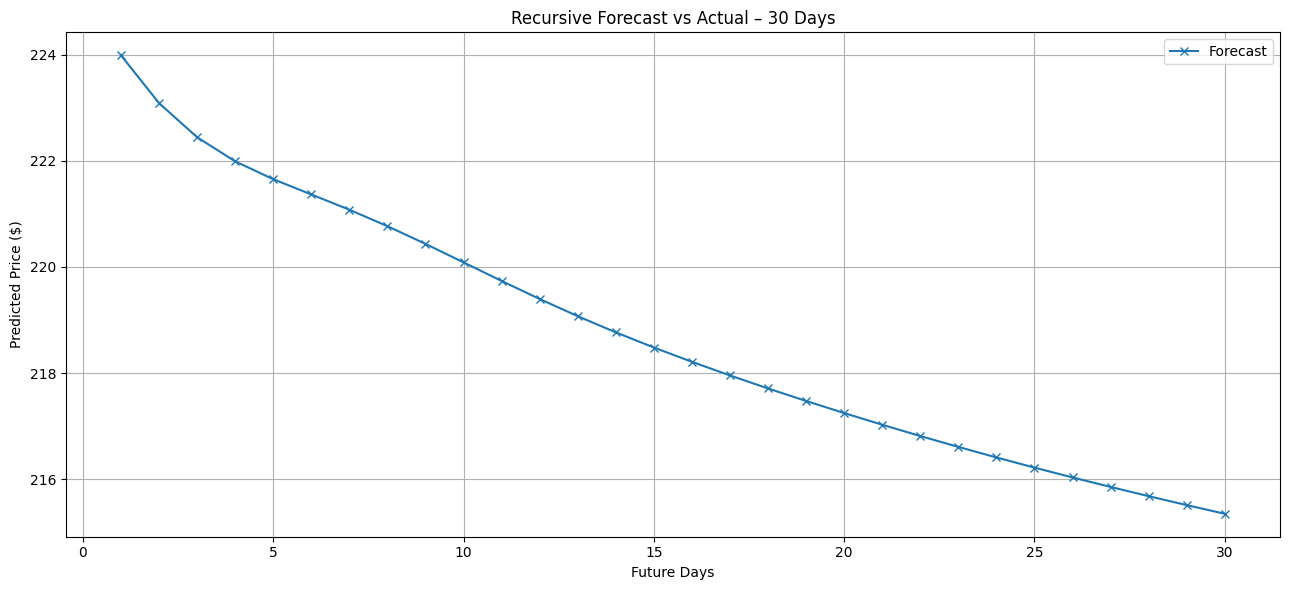

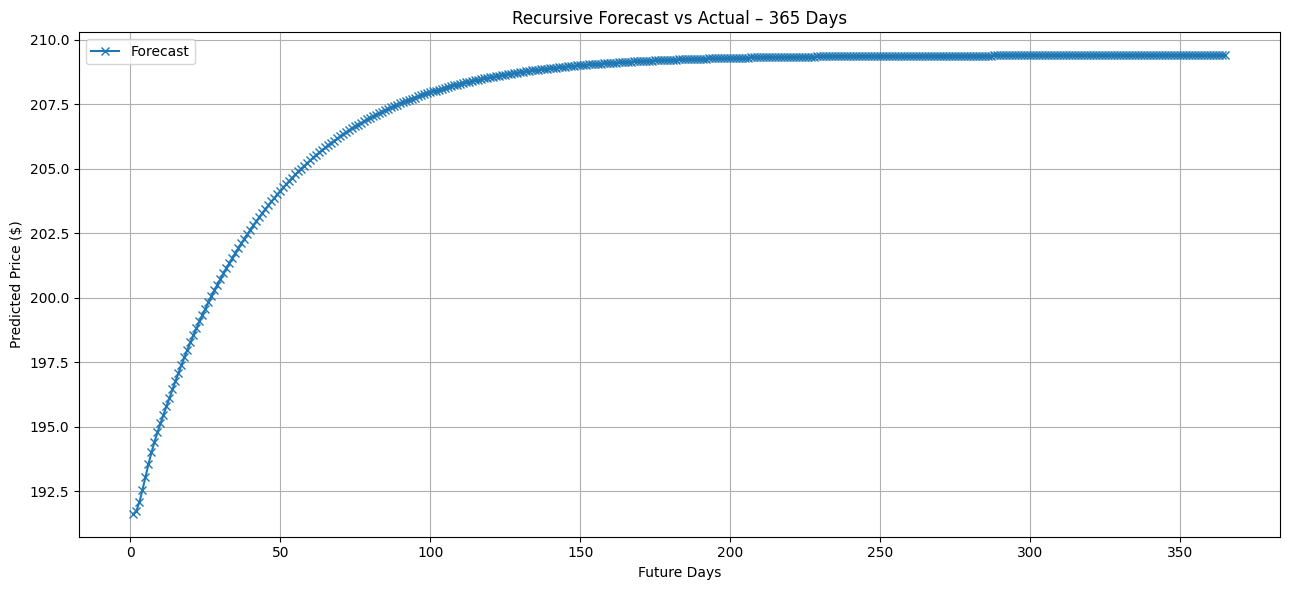

In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

def LoadingData(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    return data[['Close']].dropna()

def ScalingData(values):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)
    return scaled, scaler

def SequenceWindows(series, step):
    features = []
    labels = []
    for i in range(step, len(series)):
        features.append(series[i-step:i, 0])
        labels.append(series[i, 0])
    return np.array(features), np.array(labels)

def ModelCreation(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def train(model, Xtrain, Ytrain, Xval, Yval):
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit( Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=100, batch_size=32, callbacks=[callback], verbose=1)

def inverse_transform(scaler, data):
    return scaler.inverse_transform(data)

def plotResults(actual, predicted, title, days=30):
    plt.figure(figsize=(13, 6))
    plt.plot(actual[:days], label='Actual', marker='o')
    plt.plot(predicted[:days - 1], label='Predicted', marker='x')
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plotRecursiveForecast(predicted, title, days=30):
    plt.figure(figsize=(13, 6))
    plt.plot(range(1, days + 1), predicted, label='Forecast', marker='x')
    plt.title(title)
    plt.xlabel('Future Days')
    plt.ylabel('Predicted Price ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def recursiveForecast(model, startSequence, steps, winSize, scaler):
    output = []
    sequence = startSequence.copy()

    for _ in range(steps):
        prediction = model.predict(sequence.reshape(1, winSize, 1), verbose=0)[0][0]
        output.append(prediction)
        sequence = np.append(sequence[1:], prediction)
    
    output = np.array(output).reshape(-1, 1)
    return scaler.inverse_transform(output)

def comparison(df, scaledData, model, scaler, lookback, fdays):
    begin = len(scaledData) - fdays - lookback
    seedSequence = scaledData[begin:begin + lookback, 0]
    forecastVals = recursiveForecast(model, seedSequence, fdays, lookback, scaler)
    plotRecursiveForecast(forecastVals, f"Recursive Forecast vs Actual – {fdays} Days", fdays)

ticker = 'AAPL'
start = '2010-01-01'
end = '2025-01-01'
winSize = 180

df = LoadingData(ticker, start, end)
scaled, scaler = ScalingData(df)
X, y = SequenceWindows(scaled, winSize)
X = X.reshape(X.shape[0], X.shape[1], 1)

split = int(len(X) * 0.8)
Xtrain, Xtest = X[:split], X[split:]
Ytrain, Ytest = y[:split], y[split:]

model = ModelCreation((winSize, 1))
train(model, Xtrain, Ytrain, Xtest, Ytest)

Ypred = model.predict(Xtest)
YtestInv = inverse_transform(scaler, Ytest.reshape(-1, 1))
YpredInverse = inverse_transform(scaler, Ypred)

plotResults(YtestInv, YpredInverse, "AAPL Test Prediction – 30 Days", 30)
plotResults(YtestInv, YpredInverse, "AAPL Test Prediction – 365 Days", 365)

comparison(df, scaled, model, scaler, winSize, 30)
comparison(df, scaled, model, scaler, winSize, 365)

model.save(f"Model.h5")

# Discussing my approach

For this problem I selected Apple Inc. (AAPL) as the target stock due to its rich historical data and stable volatility, making it a better choice for forecasting models. The aim was to create an effective stock price prediction model using deep learning algorithms and forecast the stock price for two time horizons: a short-term horizon of 30 days and a long-term horizon of 365 days. To address this I experimented with two different methods. One is where the model predicts all the future prices in a single go, and another is where it recursively predicts one day at a time, feeding each prediction back into the model for the next prediction.

I obtained the dataset by using the yfinance Python library, scraping the historical data on a daily basis from 2010 through 2025. I engineered several features to provide the model with statistical and technical data. These included the log returns of the stock along with widely used technical indicators like the 50-day and 200-day Simple Moving Averages (SMA) and the Relative Strength Index (RSI). All features were scaled using MinMaxScaler to normalize the values within the $[0, 1]$ range ensuring smoother model convergence. Missing values resulting from the indicator calculations were appropriately handled using forward-fill techniques.

For the first approach the goal was to predict all future prices at once either 30 or 365 days ahead. After trying with a number of different architectures my final model architecture was a simple but effective structure. I used a single LSTM layer with 64 units followed by a single dense layer with 64 units and a final output layer that output the full sequence of future prices. The model used a tanh activation in the LSTM layer and relu in the dense layer. I have also tried a deeper model with three stacked LSTM layers (two of 128 units, one of 64) each of which are followed by LeakyReLU activations and dropout layers for regularization. The data was further processed by a dense layer with 128 units before making the final predictions. (I used 50 epochs first then decided to try 100 epochs which worked better. And I also selected the number of neurons using the rule of thumb method and then increased and decreased the neurons to find the best ones.)

While the deeper architecture was theoretically more capable of learning long-term trends it manifested overfitting tendencies particularly on the 365-day horizon despite the use of dropout (0.2–0.3) and EarlyStopping. Therefore I reverted to the shallower model which was better generalizing. I also experimented with using Bidirectional LSTMs, but they were unsuitable for this task since they consider future context, which is unrealistic for stock prediction. Similarly, I experimented with attention mechanisms, but they didn't yield significantly better accuracy—possibly due to the fact that financial time series data is noisy and non-stationary, and thus attention layers can't learn meaningful temporal dependencies.

For the second solution, in order to experiment with forecasting techniques further I used a recursive model. This model predicted one day at a time and inserted each predicted value into the model's input sequence to predict the subsequent day. The model structure here consisted of two LSTM layers with 100 and 50 units, respectively, followed by a dense output layer. This recursive structure allowed the model to react dynamically to new information on a day-by-day basis but suffered from a common problem: error accumulation. Although the recursive approach was reasonably accurate at short forecasting horizons (30 days), its predictions at longer horizons (365 days) became increasingly volatile due to compounded prediction errors.

Both approaches were contrasted with benchmark regression measures: Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). Graphic comparisons of predicted vs. actual prices were also plotted, especially handy for long-term trend capture and short-term volatility tracking. Overall, the multi-day single-shot prediction model provided us with more stability and consistency for long-term prediction, while the recursive model provided superior performance for short-term prediction due to its stepwise adjustment property.

Several hyperparameters were carefully tuned for both models. The 180-day lookback window was used, which provided enough past information to learn from patterns over long horizons. While the RMSprop optimizer was used for the direct prediction model, since it was more capable of handling noisy gradients, Adam performed better for recursive forecasting due to its faster convergence. Both were given a learning rate of 0.0005 and batch size 32, with early stopping on validation loss to prevent overtraining. (I also tried with batch 64 but 32 gave a better result)

I think the trade-offs between batch and recursive forecasting in time series modeling were more pronounced while I was working on them. Recursive forecasting is flexible and perfect for forecasting the near-future but diminishes with drift for long horizons. Predicting all future days at once can guarantee coherence across the forecast horizon but requires the model to model long-term dependencies effectively, which is challenging.